In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pylab
from pylab import legend, plot, show, title, xlabel, ylabel
import seaborn as sns
from numpy import random
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
import os
import scipy 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Problem Statement-
- To predict the final price of a used car given its various features such as horsepower,city fuel economy, mileage, volume of fuel tank, vehicle type, fuel type, maximum seating capacity, height, length ,etc.

In [1]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder.appName("UsedCarsData").getOrCreate()

In [2]:
# path=r'used_cars_data.csv'
# cars=pd.read_csv(path)

In [3]:
# cars=cars.drop('description',axis=1)

In [4]:
# cars.columns

In [5]:
# Save the DataFrame as a CSV file
# cars.to_csv('spark_used_cars.csv', index=False)

In [6]:
# lst=list(cars.columns)
# lst.remove('description')

In [7]:
# lst

In [8]:
cars = spark.read.csv("spark_used_cars.csv", header=True, inferSchema=True)

In [9]:
cars.show()

+-----------------+------------+----+----------+----------+---------------+-----+--------+-----------------+--------------------+------------+----------+----------------+-------------------+-----------+--------------------+-----+-------------+----------------+--------------+-------------+----------------+---------+-------------+-------+--------------------+----------+--------------------+-----+------------+------+------+---------+--------+--------+-----------+-------------+----------+---------+--------------------+--------------------+----------+---------------+-------+------------------+-----------+------------------+-------+-------+--------------+-------------+--------+-------------------+-----------+--------------------+------------+--------------------+------+--------------------+-----------------------+------------+--------------------+---------+-------+----+
|              vin|back_legroom| bed|bed_height|bed_length|      body_type|cabin|    city|city_fuel_economy|combine_fuel_ec

In [11]:
# cars.count()  #pandas

In [12]:
cars.printSchema()

root
 |-- vin: string (nullable = true)
 |-- back_legroom: string (nullable = true)
 |-- bed: string (nullable = true)
 |-- bed_height: string (nullable = true)
 |-- bed_length: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- cabin: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_fuel_economy: double (nullable = true)
 |-- combine_fuel_economy: string (nullable = true)
 |-- daysonmarket: integer (nullable = true)
 |-- dealer_zip: string (nullable = true)
 |-- engine_cylinders: string (nullable = true)
 |-- engine_displacement: double (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- exterior_color: string (nullable = true)
 |-- fleet: boolean (nullable = true)
 |-- frame_damaged: boolean (nullable = true)
 |-- franchise_dealer: boolean (nullable = true)
 |-- franchise_make: string (nullable = true)
 |-- front_legroom: string (nullable = true)
 |-- fuel_tank_volume: string (nullable = true)
 |-- fuel_type: string (nullable = 

### The following heatmap shows a visual representation of null values in the entire dataset

In [13]:
# sns.heatmap(cars.isna()) 

### Checking null value counts by converting it into percentage

In [14]:
cars

DataFrame[vin: string, back_legroom: string, bed: string, bed_height: string, bed_length: string, body_type: string, cabin: string, city: string, city_fuel_economy: double, combine_fuel_economy: string, daysonmarket: int, dealer_zip: string, engine_cylinders: string, engine_displacement: double, engine_type: string, exterior_color: string, fleet: boolean, frame_damaged: boolean, franchise_dealer: boolean, franchise_make: string, front_legroom: string, fuel_tank_volume: string, fuel_type: string, has_accidents: boolean, height: string, highway_fuel_economy: double, horsepower: double, interior_color: string, isCab: boolean, is_certified: string, is_cpo: boolean, is_new: boolean, is_oemcpo: boolean, latitude: double, length: string, listed_date: date, listing_color: string, listing_id: int, longitude: double, main_picture_url: string, major_options: string, make_name: string, maximum_seating: string, mileage: double, model_name: string, owner_count: double, power: string, price: double, 

In [15]:
from pyspark.sql import functions as F

# Get total row count
total_rows = cars.count()

# Calculate null percentage for each column
null_percentages = cars.select([
    (F.count(F.when(F.col(c).isNull(), c)) / total_rows * 100).alias(c)
    for c in cars.columns
])

# Convert to a long format (column name, null percentage)
null_percentages_long = null_percentages.selectExpr(
    "stack(" + str(len(cars.columns)) + ", " +
    ", ".join([f"'{col}', {col}" for col in cars.columns]) + ") as (Column, Null_Percentage)"
)

# Sort in descending order by Null_Percentage
null_percentages_sorted = null_percentages_long.orderBy(F.col("Null_Percentage").desc())

# Show the result
null_percentages_sorted.show(n=len(cars.columns), truncate=False)


+-----------------------+---------------------+
|Column                 |Null_Percentage      |
+-----------------------+---------------------+
|combine_fuel_economy   |100.0                |
|is_certified           |100.0                |
|vehicle_damage_category|100.0                |
|bed                    |99.34774203010626    |
|cabin                  |97.88226156984572    |
|is_oemcpo              |95.48799349342009    |
|is_cpo                 |93.90348128691618    |
|bed_height             |85.69692404101279    |
|bed_length             |85.69692404101279    |
|owner_count            |50.56642578098959    |
|fleet                  |47.55253263289823    |
|frame_damaged          |47.55253263289823    |
|has_accidents          |47.55253263289823    |
|isCab                  |47.55253263289823    |
|salvage                |47.55253263289823    |
|theft_title            |47.55253263289823    |
|franchise_make         |19.087578832282237   |
|torque                 |17.259536539512

In [16]:
# pd.set_option('display.max_rows', None)
# print(df_null_perc)
# pd.reset_option('display.max_rows', None)

In [17]:
type(cars)

pyspark.sql.dataframe.DataFrame

In [18]:
shape = (cars.count(), len(cars.columns))
print(f"Shape of DataFrame: {shape}")   # checking the number of columns and rows 

Shape of DataFrame: (3000040, 65)


### Dropping columns which contains null values greater than 80%

In [19]:
null_percentages_sorted.show(n=len(cars.columns), truncate=False)

+-----------------------+---------------------+
|Column                 |Null_Percentage      |
+-----------------------+---------------------+
|combine_fuel_economy   |100.0                |
|is_certified           |100.0                |
|vehicle_damage_category|100.0                |
|bed                    |99.34774203010626    |
|cabin                  |97.88226156984572    |
|is_oemcpo              |95.48799349342009    |
|is_cpo                 |93.90348128691618    |
|bed_height             |85.69692404101279    |
|bed_length             |85.69692404101279    |
|owner_count            |50.56642578098959    |
|fleet                  |47.55253263289823    |
|frame_damaged          |47.55253263289823    |
|has_accidents          |47.55253263289823    |
|isCab                  |47.55253263289823    |
|salvage                |47.55253263289823    |
|theft_title            |47.55253263289823    |
|franchise_make         |19.087578832282237   |
|torque                 |17.259536539512

In [20]:
# Import functions
from pyspark.sql.functions import col

# Filter rows where Null_Percentage > 80 and select only the Column names
filtered_columns = (
    null_percentages_sorted
    .filter(col("Null_Percentage") < 80)
    # .select("Column")  # Select only the column names
    # .rdd.flatMap(lambda x: x)  # Convert to a list
    # .collect()
)

# print(filtered_columns.show())  # Equivalent to .index in Pandas
# filtered_columns.show()
cleaned_cars=filtered_columns
cleaned_cars.show(n=len(cars.columns), truncate=False)  #spark dataframe after removing columns with more than 80% null values.

+--------------------+---------------------+
|Column              |Null_Percentage      |
+--------------------+---------------------+
|owner_count         |50.56642578098959    |
|fleet               |47.55253263289823    |
|frame_damaged       |47.55253263289823    |
|has_accidents       |47.55253263289823    |
|isCab               |47.55253263289823    |
|salvage             |47.55253263289823    |
|theft_title         |47.55253263289823    |
|franchise_make      |19.087578832282237   |
|torque              |17.25953653951281    |
|city_fuel_economy   |16.37594832068906    |
|highway_fuel_economy|16.37594832068906    |
|power               |16.04731936907508    |
|interior_color      |12.79936267516433    |
|main_picture_url    |12.302935960853855   |
|major_options       |6.6681777576298975   |
|engine_displacement |5.746123385021533    |
|horsepower          |5.746123385021533    |
|back_legroom        |5.308895881388248    |
|front_legroom       |5.308895881388248    |
|fuel_tank

In [21]:
# df_nulls=null_percentages_sorted[null_percentages_sorted>80].index
# df_nulls

In [22]:
# df_nulls=df_null_perc[df_null_perc>80].index   #stores the columns with more than 80% null values
# df_nulls

In [23]:
cleaned_cars=cars.drop(df_nulls,axis=1) 

NameError: name 'df_nulls' is not defined

In [ ]:
((cleaned_cars.isna().sum()/cleaned_cars.shape[0])*100).sort_values(ascending=False) #thus high null value columns are dropped

### Checking columns which contains null values between 45 and 51 

In [24]:
# Import functions
from pyspark.sql.functions import col

# Filter rows where Null_Percentage > 80 and select only the Column names
df_nulls_45_and_51 = (
    cleaned_cars
    .filter((col("Null_Percentage") > 45) & (col("Null_Percentage") < 51))
)

df_nulls_45_and_51.show(n=len(cars.columns), truncate=False)  #spark dataframe after removing columns with more than 80% null values.

+-------------+-----------------+
|Column       |Null_Percentage  |
+-------------+-----------------+
|owner_count  |50.56642578098959|
|fleet        |47.55253263289823|
|frame_damaged|47.55253263289823|
|has_accidents|47.55253263289823|
|isCab        |47.55253263289823|
|salvage      |47.55253263289823|
|theft_title  |47.55253263289823|
+-------------+-----------------+



In [25]:
column_names = df_nulls_45_and_51.select("Column")

# print(column_names.show())
for i in column_names.collect():
    print(i.Column)
    cars.groupBy(i.Column).count().show()

owner_count
+-----------+-------+
|owner_count|  count|
+-----------+-------+
|        8.0|    836|
|        7.0|   1977|
|       NULL|1517013|
|        1.0| 972936|
|        4.0|  39764|
|       11.0|     73|
|        3.0| 116775|
|        2.0| 330624|
|       10.0|    128|
|        6.0|   5286|
|        5.0|  14207|
|       15.0|      6|
|        9.0|    366|
|       12.0|     21|
|       13.0|     16|
|       14.0|      7|
|       19.0|      1|
|       18.0|      1|
|       16.0|      3|
+-----------+-------+

fleet
+-----+-------+
|fleet|  count|
+-----+-------+
| NULL|1426595|
| true| 334938|
|false|1238507|
+-----+-------+

frame_damaged
+-------------+-------+
|frame_damaged|  count|
+-------------+-------+
|         NULL|1426595|
|         true|  14951|
|        false|1558494|
+-------------+-------+

has_accidents
+-------------+-------+
|has_accidents|  count|
+-------------+-------+
|         NULL|1426595|
|         true| 242954|
|        false|1330491|
+-------------+------

In [14]:
df_nulls_45_and_51=df_null_perc[(df_null_perc<51) & (df_null_perc>45)]#.index 

In [15]:
df_nulls_45_and_51

owner_count      50.566426
salvage          47.552533
theft_title      47.552533
frame_damaged    47.552533
fleet            47.552533
has_accidents    47.552533
isCab            47.552533
dtype: float64

In [16]:
cleaned_cars[df_nulls_45_and_51.index]#.value_counts()

,owner_count,salvage,theft_title,frame_damaged,fleet,has_accidents,isCab
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,False,False,False,False,False,False
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3000035,1.0,False,False,False,True,False,True
3000036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000037,2.0,False,False,False,False,True,False
3000038,1.0,False,False,False,False,False,False


In [17]:
#for finding unique values in columns having  between 45 to 51 % of null values
for i in df_nulls_45_and_51.index:
    print(cleaned_cars[i].value_counts())
    print()

owner_count
1.0     972936
2.0     330624
3.0     116775
4.0      39764
5.0      14207
6.0       5286
7.0       1977
8.0        836
9.0        366
10.0       128
11.0        73
12.0        21
13.0        16
14.0         7
15.0         6
16.0         3
19.0         1
18.0         1
Name: count, dtype: int64

salvage
False    1562918
True       10527
Name: count, dtype: int64

theft_title
False    1568179
True        5266
Name: count, dtype: int64

frame_damaged
False    1558494
True       14951
Name: count, dtype: int64

fleet
False    1238507
True      334938
Name: count, dtype: int64

has_accidents
False    1330491
True      242954
Name: count, dtype: int64

isCab
False    1286504
True      286941
Name: count, dtype: int64



for fleet dataset-
 
False    12,38,507 ~12 lakhs  4

True      3,34,938 ~3 lakhs   1

# Data Cleaning-

#### For most columns between 45 and 50 % null values we have imputed those values with the ratio of the values in the respective columns which are not null

In [18]:
#random example for shuffling values
x=np.array([1,1,1,1,1,2,2,2,2,2,2,2])
np.random.shuffle(x)

In [19]:
x

array([2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1])

**For fleet-**

In [20]:
cleaned_cars['fleet']

0            NaN
1            NaN
2          False
3            NaN
4            NaN
           ...  
3000035     True
3000036      NaN
3000037    False
3000038    False
3000039    False
Name: fleet, Length: 3000040, dtype: object

In [21]:
nl_fleet=np.where(cleaned_cars['fleet'].isnull())[0]
nl_fleet

array([      0,       1,       3, ..., 3000029, 3000032, 3000036])

In [22]:
cleaned_cars['fleet'].value_counts()


fleet
False    1238507
True      334938
Name: count, dtype: int64

In [23]:
cleaned_cars['fleet'].value_counts()/1573445


fleet
False    0.787131
True     0.212869
Name: count, dtype: float64

In [26]:
cars.groupBy('fleet').count().show()

+-----+-------+
|fleet|  count|
+-----+-------+
| NULL|1426595|
| true| 334938|
|false|1238507|
+-----+-------+



In [27]:
from pyspark.sql.functions import col, count, lit

# Get total number of rows
total_rows = cars.count()

# Calculate the percentage for each unique value in the 'fleet' column
cars.groupBy("fleet") \
    .agg(count("*").alias("count")) \
    .withColumn("percentage", col("count") / lit(total_rows-1426595) * 100) \
    .orderBy(col("count").desc()) \
    .show()


+-----+-------+------------------+
|fleet|  count|        percentage|
+-----+-------+------------------+
| NULL|1426595| 90.66697596674813|
|false|1238507| 78.71307862683474|
| true| 334938|21.286921373165253|
+-----+-------+------------------+



In [35]:
#False values are approxiamtely 80%
#True values are approxiamtely 20%


#### 80:20 = 4:1  = False:True in is_accidents
#### So we fill null values in the ratio 4:1 for False:True

In [24]:
cleaned_cars['fleet'].isna().sum()  #total null values


np.int64(1426595)

In [25]:
cleaned_cars['fleet'].isna().sum()/5

np.float64(285319.0)

In [26]:
print('True',285319)
print('False',285319*4)


True 285319
False 1141276


In [27]:
1141276+285319

1426595

In [28]:
np.array(([1,0]*5)).astype(bool)


array([ True, False,  True, False,  True, False,  True, False,  True,
       False])

In [29]:
arr_of_1_0_for_fleet=np.array([1]*285319+[0]*1141276).astype(bool)
arr_of_1_0_for_fleet

array([ True,  True,  True, ..., False, False, False])

In [30]:
sum(arr_of_1_0_for_fleet)

np.int64(285319)

In [31]:
np.random.shuffle(arr_of_1_0_for_fleet)

In [32]:
# pd.reset_option('display.max_rows', None)

In [33]:
arr_of_1_0_for_fleet

array([False, False, False, ...,  True, False, False])

In [34]:
nl_fleet  #null values indices

array([      0,       1,       3, ..., 3000029, 3000032, 3000036])

#### Filling null values with imputed values-

In [35]:
cleaned_cars.loc[nl_fleet,'fleet']=arr_of_1_0_for_fleet

In [36]:
cleaned_cars['fleet'].isna().sum()

np.int64(0)

In [37]:
# for i in arr_of_1_0_for_has_acc:print(i)

**for has_accidents-**

In [38]:
cleaned_cars['has_accidents']

0            NaN
1            NaN
2          False
3            NaN
4            NaN
           ...  
3000035    False
3000036      NaN
3000037     True
3000038    False
3000039    False
Name: has_accidents, Length: 3000040, dtype: object

In [39]:
nl_has_acc=np.where(cleaned_cars['has_accidents'].isnull())[0]
nl_has_acc

array([      0,       1,       3, ..., 3000029, 3000032, 3000036])

In [40]:
cleaned_cars['has_accidents'].value_counts()

has_accidents
False    1330491
True      242954
Name: count, dtype: int64

In [41]:
1330491+242954

1573445

In [42]:
cleaned_cars['has_accidents'].value_counts()/1573445

has_accidents
False    0.845591
True     0.154409
Name: count, dtype: float64

In [32]:
from pyspark.sql.functions import col, count, lit

# Get total number of rows
total_rows = cars.count()

# Calculate the percentage for each unique value in the 'fleet' column
cars.groupBy("has_accidents") \
    .agg(count("*").alias("count")) \
    .withColumn("percentage", col("count") / lit(total_rows-1426595) * 100) \
    .orderBy(col("count").desc()) \
    .show()


+-------------+-------+-----------------+
|has_accidents|  count|       percentage|
+-------------+-------+-----------------+
|         NULL|1426595|90.66697596674813|
|        false|1330491|84.55910438559975|
|         true| 242954|15.44089561440025|
+-------------+-------+-----------------+



In [43]:
# approx 80:20 = 4:1  = False:True in has_accidents

In [44]:
cleaned_cars['has_accidents'].isna().sum()  #total null values

np.int64(1426595)

In [45]:
cleaned_cars['has_accidents'].isna().sum()/5

np.float64(285319.0)

In [46]:
print('True',285319)
print('False',285319*4)


True 285319
False 1141276


In [47]:
1141276+285319

1426595

In [48]:
np.array(([1,0]*5)).astype(bool)

array([ True, False,  True, False,  True, False,  True, False,  True,
       False])

In [49]:
arr_of_1_0_for_has_acc=np.array([1]*285319+[0]*1141276).astype(bool)
arr_of_1_0_for_has_acc

array([ True,  True,  True, ..., False, False, False])

In [50]:
sum(arr_of_1_0_for_has_acc)

np.int64(285319)

In [51]:
np.random.shuffle(arr_of_1_0_for_has_acc)

In [52]:
pd.reset_option('display.max_rows', None)

In [53]:
arr_of_1_0_for_has_acc

array([False, False, False, ...,  True, False, False])

In [54]:
nl_has_acc

array([      0,       1,       3, ..., 3000029, 3000032, 3000036])

In [55]:
cleaned_cars.loc[nl_has_acc,'has_accidents']=arr_of_1_0_for_has_acc

In [56]:
cleaned_cars['has_accidents'].isna().sum()

np.int64(0)

In [57]:
# for i in arr_of_1_0_for_has_acc:print(i)

**for salvage**

In [58]:
nl_salvage=np.where(cleaned_cars['salvage'].isnull())[0]
nl_salvage

array([      0,       1,       3, ..., 3000029, 3000032, 3000036])

In [59]:
cleaned_cars['salvage'].value_counts()

salvage
False    1562918
True       10527
Name: count, dtype: int64

In [60]:
1562918+10527

1573445

In [61]:
cleaned_cars['salvage'].value_counts()/1573445   #can remove 'salvage' column since it has nearly 100% False values

salvage
False    0.99331
True     0.00669
Name: count, dtype: float64

In [35]:
from pyspark.sql.functions import col, count, lit

# Get total number of rows
total_rows = cars.count()

# Calculate the percentage for each unique value in the 'fleet' column
cars.groupBy("salvage") \
    .agg(count("*").alias("count")) \
    .withColumn("percentage", col("count") / lit(total_rows-1426595) * 100) \
    .orderBy(col("count").desc()) \
    .show()


+-------+-------+------------------+
|salvage|  count|        percentage|
+-------+-------+------------------+
|  false|1562918| 99.33095850188599|
|   NULL|1426595| 90.66697596674813|
|   true|  10527|0.6690414981140109|
+-------+-------+------------------+



**for theft_title-**

In [62]:
nl_theft=np.where(cleaned_cars['theft_title'].isnull())[0]
nl_theft

array([      0,       1,       3, ..., 3000029, 3000032, 3000036])

In [63]:
cleaned_cars['theft_title'].value_counts()

theft_title
False    1568179
True        5266
Name: count, dtype: int64

In [64]:
1568179+5266

1573445

In [65]:
cleaned_cars['theft_title'].value_counts()/1573445   #can remove 'theft_title' column since it has nearly 100% False values

theft_title
False    0.996653
True     0.003347
Name: count, dtype: float64

In [36]:
from pyspark.sql.functions import col, count, lit

# Get total number of rows
total_rows = cars.count()

# Calculate the percentage for each unique value in the 'fleet' column
cars.groupBy("theft_title") \
    .agg(count("*").alias("count")) \
    .withColumn("percentage", col("count") / lit(total_rows-1426595) * 100) \
    .orderBy(col("count").desc()) \
    .show()


+-----------+-------+------------------+
|theft_title|  count|        percentage|
+-----------+-------+------------------+
|      false|1568179| 99.66532036391484|
|       NULL|1426595| 90.66697596674813|
|       true|   5266|0.3346796360851507|
+-----------+-------+------------------+



**for frame_damaged-**


In [66]:
nl_frame_damaged=np.where(cleaned_cars['frame_damaged'].isnull())[0]
nl_frame_damaged

array([      0,       1,       3, ..., 3000029, 3000032, 3000036])

In [67]:
cleaned_cars['frame_damaged'].value_counts()


frame_damaged
False    1558494
True       14951
Name: count, dtype: int64

In [68]:
1558494+14951

1573445

In [69]:
cleaned_cars['frame_damaged'].value_counts()/1573445   #can remove 'frame_damaged' column since it has nearly 100% False values


frame_damaged
False    0.990498
True     0.009502
Name: count, dtype: float64

In [70]:
df_nulls_45_and_51.index


Index(['owner_count', 'salvage', 'theft_title', 'frame_damaged', 'fleet',
       'has_accidents', 'isCab'],
      dtype='object')

**for isCab-**


In [71]:
nl_isCab=np.where(cleaned_cars['isCab'].isnull())[0]
nl_isCab

array([      0,       1,       3, ..., 3000029, 3000032, 3000036])

In [72]:
cleaned_cars['isCab'].value_counts()


isCab
False    1286504
True      286941
Name: count, dtype: int64

In [73]:
1286504+286941

1573445

In [74]:
cleaned_cars['isCab'].value_counts()/1573445   #can remove 'frame_damaged' column since it has nearly 100% False values


isCab
False    0.817635
True     0.182365
Name: count, dtype: float64

In [37]:
from pyspark.sql.functions import col, count, lit

# Get total number of rows
total_rows = cars.count()

# Calculate the percentage for each unique value in the 'fleet' column
cars.groupBy("isCab") \
    .agg(count("*").alias("count")) \
    .withColumn("percentage", col("count") / lit(total_rows-1426595) * 100) \
    .orderBy(col("count").desc()) \
    .show()


+-----+-------+------------------+
|isCab|  count|        percentage|
+-----+-------+------------------+
| NULL|1426595| 90.66697596674813|
|false|1286504| 81.76351890278973|
| true| 286941|18.236481097210262|
+-----+-------+------------------+



In [75]:
# approx 80:20 = 4:1  = False:True in isCab

In [76]:
cleaned_cars['isCab'].isna().sum()/5


np.float64(285319.0)

In [77]:
print('True',285319)
print('False',285319*4)


True 285319
False 1141276


In [78]:
arr_of_1_0_for_isCab=np.array([1]*285319+[0]*1141276).astype(bool)
arr_of_1_0_for_isCab

array([ True,  True,  True, ..., False, False, False])

In [79]:
sum(arr_of_1_0_for_isCab)  #total true values to be filled for null values. remaining will be false

np.int64(285319)

In [80]:
np.random.shuffle(arr_of_1_0_for_isCab)

In [81]:
cleaned_cars.loc[nl_isCab,'isCab']=arr_of_1_0_for_has_acc

In [82]:
cleaned_cars

,vin,back_legroom,body_type,city,city_fuel_economy,daysonmarket,dealer_zip,description,engine_cylinders,engine_displacement,...,torque,transmission,transmission_display,trimId,trim_name,wheel_system,wheel_system_display,wheelbase,width,year
0,ZACNJABB5KPJ92081,35.1 in,SUV / Crossover,Bayamon,NaN,522,960,[!@@Additional Info@@!]Engine: 2.4L I4 ZERO EV...,I4,1300.0,...,"200 lb-ft @ 1,750 RPM",A,9-Speed Automatic Overdrive,t83804,Latitude FWD,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,SALCJ2FX1LH858117,38.1 in,SUV / Crossover,San Juan,NaN,207,922,"[!@@Additional Info@@!]Keyless Entry,Ebony Mor...",I4,2000.0,...,"269 lb-ft @ 1,400 RPM",A,9-Speed Automatic Overdrive,t86759,S AWD,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,JF1VA2M67G9829723,35.4 in,Sedan,Guaynabo,17.0,1233,969,NaN,H4,2500.0,...,"290 lb-ft @ 4,000 RPM",M,6-Speed Manual,t58994,Base,AWD,All-Wheel Drive,104.3 in,78.9 in,2016
3,SALRR2RV0L2433391,37.6 in,SUV / Crossover,San Juan,NaN,196,922,"[!@@Additional Info@@!]Fog Lights,7 Seat Packa...",V6,3000.0,...,"332 lb-ft @ 3,500 RPM",A,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,AWD,All-Wheel Drive,115 in,87.4 in,2020
4,SALCJ2FXXLH862327,38.1 in,SUV / Crossover,San Juan,NaN,137,922,"[!@@Additional Info@@!]Keyless Entry,Ebony Mor...",I4,2000.0,...,"269 lb-ft @ 1,400 RPM",A,9-Speed Automatic Overdrive,t86759,S AWD,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000035,2GNAXJEV0J6261526,39.7 in,SUV / Crossover,Fairfield,26.0,16,94533,CarMax Curbside is now available at select sto...,I4,1500.0,...,NaN,A,Automatic,t72936,1.5T LT FWD,FWD,Front-Wheel Drive,107.3 in,72.6 in,2018
3000036,1GNERFKW0LJ225508,38.4 in,SUV / Crossover,Vallejo,18.0,171,94591,Prices do not include government fees and taxe...,V6,3600.0,...,"266 lb-ft @ 2,800 RPM",A,Automatic,t85763,LS FWD,FWD,Front-Wheel Drive,120.9 in,78.6 in,2020
3000037,3FA6P0HD3GR134062,38.3 in,Sedan,Napa,NaN,91,94559,Introducing the 2016 Ford Fusion! Offering an ...,NaN,2000.0,...,"270 lb-ft @ 1,750 RPM",A,6-Speed Automatic Overdrive,t57569,SE,FWD,Front-Wheel Drive,112.2 in,83.5 in,2016
3000038,SAJAJ4BNXHA968809,35 in,Sedan,Fairfield,30.0,11,94533,CarMax Curbside is now available at select sto...,I4 Diesel,2000.0,...,"318 lb-ft @ 1,750 RPM",A,Automatic,t65977,20d Premium AWD,AWD,All-Wheel Drive,111.6 in,81.7 in,2017


In [83]:
cleaned_cars_null_perc=((cleaned_cars.isna().sum()/cleaned_cars.shape[0])*100).sort_values(ascending=False)
cleaned_cars_null_perc

owner_count             50.566426
salvage                 47.552533
theft_title             47.552533
frame_damaged           47.552533
franchise_make          19.087579
torque                  17.259537
highway_fuel_economy    16.375948
city_fuel_economy       16.375948
power                   16.047319
interior_color          12.799363
main_picture_url        12.302936
major_options            6.668178
horsepower               5.746123
engine_displacement      5.746123
height                   5.308896
length                   5.308896
width                    5.308896
maximum_seating          5.308896
front_legroom            5.308896
back_legroom             5.308896
fuel_tank_volume         5.308896
wheelbase                5.308896
wheel_system             4.891001
wheel_system_display     4.891001
mileage                  4.812836
trim_name                3.876415
trimId                   3.860849
engine_type              3.352655
engine_cylinders         3.352655
fuel_type     

#### salvage,theft_title,frame_damaged have narly 100% false values. We can either directly drop this column or fill it entirely with false values.

In [84]:
cleaned_cars=cleaned_cars.drop(['salvage','theft_title'],axis=1)
cleaned_cars['frame_damaged']=cleaned_cars['frame_damaged'].fillna(False)


C:\Users\AAYUSH\AppData\Local\Temp\ipykernel_1588\3172463234.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_cars['frame_damaged']=cleaned_cars['frame_damaged'].fillna(False)


In [85]:
cleaned_cars_null_perc=((cleaned_cars.isna().sum()/cleaned_cars.shape[0])*100).sort_values(ascending=False)   #checking null value percentages
cleaned_cars_null_perc

owner_count             50.566426
franchise_make          19.087579
torque                  17.259537
highway_fuel_economy    16.375948
city_fuel_economy       16.375948
power                   16.047319
interior_color          12.799363
main_picture_url        12.302936
major_options            6.668178
horsepower               5.746123
engine_displacement      5.746123
fuel_tank_volume         5.308896
height                   5.308896
wheelbase                5.308896
width                    5.308896
length                   5.308896
maximum_seating          5.308896
back_legroom             5.308896
front_legroom            5.308896
wheel_system_display     4.891001
wheel_system             4.891001
mileage                  4.812836
trim_name                3.876415
trimId                   3.860849
engine_type              3.352655
engine_cylinders         3.352655
fuel_type                2.757430
description              2.596665
transmission_display     2.139471
transmission  

In [86]:
cleaned_cars['owner_count'].value_counts()

owner_count
1.0     972936
2.0     330624
3.0     116775
4.0      39764
5.0      14207
6.0       5286
7.0       1977
8.0        836
9.0        366
10.0       128
11.0        73
12.0        21
13.0        16
14.0         7
15.0         6
16.0         3
19.0         1
18.0         1
Name: count, dtype: int64

(0.0, 5.0)

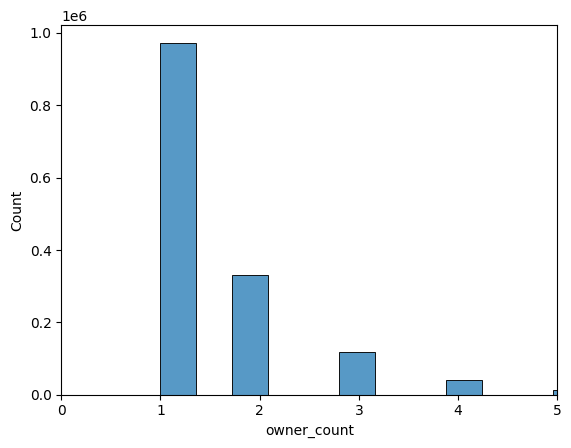

In [87]:
sns.histplot(cleaned_cars,x='owner_count',bins=50)
plt.xlim([0,5])

#### from above histogram we can conclude that the graph is a right skewed graph.

In [88]:
cleaned_cars['owner_count']=cleaned_cars['owner_count'].fillna(1)  #filling null values of 'owner count' with mode which is 1.

In [89]:
cleaned_cars_null_perc=((cleaned_cars.isna().sum()/cleaned_cars.shape[0])*100).sort_values(ascending=False)
cleaned_cars_null_perc

franchise_make          19.087579
torque                  17.259537
highway_fuel_economy    16.375948
city_fuel_economy       16.375948
power                   16.047319
interior_color          12.799363
main_picture_url        12.302936
major_options            6.668178
horsepower               5.746123
engine_displacement      5.746123
wheelbase                5.308896
fuel_tank_volume         5.308896
height                   5.308896
back_legroom             5.308896
width                    5.308896
length                   5.308896
maximum_seating          5.308896
front_legroom            5.308896
wheel_system_display     4.891001
wheel_system             4.891001
mileage                  4.812836
trim_name                3.876415
trimId                   3.860849
engine_cylinders         3.352655
engine_type              3.352655
fuel_type                2.757430
description              2.596665
transmission             2.139471
transmission_display     2.139471
exterior_color

In [90]:
#for finding unique values in columns having  between 10 and 20% of null values
df_nulls_10_and_20=df_null_perc[(df_null_perc<20) & (df_null_perc>10)]#.index 
for i in df_nulls_10_and_20.index:
    print(cleaned_cars[i].value_counts())
    print()

franchise_make
Ford             395521
Chevrolet        338817
Toyota           186718
Honda            184515
Jeep             177100
Nissan           152590
Hyundai          107099
Kia               92690
RAM               77079
Buick             74419
Volkswagen        62430
Subaru            60899
GMC               60677
Dodge             49212
Mercedes-Benz     45867
Mazda             45743
BMW               45540
Cadillac          35081
Lexus             28602
Audi              26896
Acura             26282
Lincoln           25535
Mitsubishi        20079
Chrysler          19563
Volvo             19353
INFINITI          18665
Land Rover        12662
Porsche           10897
MINI               5448
Jaguar             4965
FIAT               4207
Scion              3976
Maserati           2598
Alfa Romeo         1486
Genesis            1123
Bentley             541
Rolls-Royce         506
Aston Martin        482
Ferrari             458
Lotus               436
McLaren             309
L

In [91]:
x=cleaned_cars['franchise_make'].dropna()

In [92]:
x.shape

(2427405,)

In [93]:
(3000040, 66)

(3000040, 66)

In [94]:
cleaned_cars['franchise_make'].isna().sum()

np.int64(572635)

In [95]:
df_nulls_10_and_20.index

Index(['franchise_make', 'torque', 'city_fuel_economy', 'highway_fuel_economy',
       'power', 'interior_color', 'main_picture_url'],
      dtype='object')

In [96]:
cleaned_cars.shape

(3000040, 55)

In [97]:
cleaned_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000040 entries, 0 to 3000039
Data columns (total 55 columns):
 #   Column                Dtype  
---  ------                -----  
 0   vin                   object 
 1   back_legroom          object 
 2   body_type             object 
 3   city                  object 
 4   city_fuel_economy     float64
 5   daysonmarket          int64  
 6   dealer_zip            object 
 7   description           object 
 8   engine_cylinders      object 
 9   engine_displacement   float64
 10  engine_type           object 
 11  exterior_color        object 
 12  fleet                 object 
 13  frame_damaged         bool   
 14  franchise_dealer      bool   
 15  franchise_make        object 
 16  front_legroom         object 
 17  fuel_tank_volume      object 
 18  fuel_type             object 
 19  has_accidents         object 
 20  height                object 
 21  highway_fuel_economy  float64
 22  horsepower            float64
 23  interio

In [98]:
cleaned_cars_null_perc=((cleaned_cars.isna().sum()/cleaned_cars.shape[0])*100).sort_values(ascending=False)
cleaned_cars_null_perc

franchise_make          19.087579
torque                  17.259537
highway_fuel_economy    16.375948
city_fuel_economy       16.375948
power                   16.047319
interior_color          12.799363
main_picture_url        12.302936
major_options            6.668178
horsepower               5.746123
engine_displacement      5.746123
wheelbase                5.308896
fuel_tank_volume         5.308896
height                   5.308896
back_legroom             5.308896
width                    5.308896
length                   5.308896
maximum_seating          5.308896
front_legroom            5.308896
wheel_system_display     4.891001
wheel_system             4.891001
mileage                  4.812836
trim_name                3.876415
trimId                   3.860849
engine_cylinders         3.352655
engine_type              3.352655
fuel_type                2.757430
description              2.596665
transmission             2.139471
transmission_display     2.139471
exterior_color

In [99]:
null_frach=np.where(cleaned_cars['franchise_make'].isna())
null_frach

(array([    220,     221,     223, ..., 3000033, 3000035, 3000038]),)

In [100]:
cleaned_cars = cleaned_cars.dropna(subset=df_nulls_10_and_20.index)  #we directly drop null values for columns containing between 10 and 20 % null values

In [101]:
# dropping 'main_picture_url', since links are of no use
cleaned_cars=cleaned_cars.drop('main_picture_url',axis=1)

In [102]:
cleaned_cars_null_perc=((cleaned_cars.isna().sum()/cleaned_cars.shape[0])*100).sort_values(ascending=False)
cleaned_cars_null_perc

mileage                 4.407650
major_options           3.441731
description             1.151630
seller_rating           0.800972
transmission            0.729100
transmission_display    0.729100
exterior_color          0.174232
wheel_system            0.069240
wheel_system_display    0.069240
length                  0.016085
fuel_tank_volume        0.016085
maximum_seating         0.016085
width                   0.016085
wheelbase               0.016085
back_legroom            0.016085
front_legroom           0.016085
height                  0.016085
body_type               0.001609
engine_cylinders        0.001097
engine_type             0.001097
fuel_type               0.000804
daysonmarket            0.000000
highway_fuel_economy    0.000000
has_accidents           0.000000
franchise_make          0.000000
franchise_dealer        0.000000
engine_displacement     0.000000
dealer_zip              0.000000
fleet                   0.000000
frame_damaged           0.000000
vin       

In [103]:
cleaned_cars['mileage'].value_counts()

mileage
0.0         128652
5.0          78297
10.0         76418
3.0          42120
2.0          41637
             ...  
128216.0         1
123184.0         1
105128.0         1
83906.0          1
87219.0          1
Name: count, Length: 127283, dtype: int64

- mileage column will be filled with median values. 

These columns are complex and should be dropped -
1. major_options          
2. description   

In [104]:
cleaned_cars['major_options'].value_counts()


major_options
['Alloy Wheels', 'Bluetooth', 'Backup Camera']                                                                                                                                                                                                                                                              40403
['Steel Wheels', 'Bluetooth', 'Backup Camera']                                                                                                                                                                                                                                                              15614
['Bluetooth', 'Backup Camera']                                                                                                                                                                                                                                                                              14526
['Alloy Wheels', 'Bluetooth', 'Backup Camera', 'Android Auto', 'CarP

In [202]:
cleaned_cars['description'].value_counts()

KeyError: 'description'

In [106]:
cleaned_cars=cleaned_cars.drop(['major_options','description'],axis=1)

In [107]:
cleaned_cars['mileage']=cleaned_cars['mileage'].fillna(np.median(cleaned_cars.dropna()['mileage']))

In [108]:
np.median(cleaned_cars.dropna()['mileage'])

np.float64(25.0)

In [109]:
cleaned_cars_null_perc=((cleaned_cars.isna().sum()/cleaned_cars.shape[0])*100).sort_values(ascending=False)
cleaned_cars_null_perc

seller_rating           0.800972
transmission            0.729100
transmission_display    0.729100
exterior_color          0.174232
wheel_system            0.069240
wheel_system_display    0.069240
length                  0.016085
wheelbase               0.016085
front_legroom           0.016085
back_legroom            0.016085
height                  0.016085
width                   0.016085
maximum_seating         0.016085
fuel_tank_volume        0.016085
body_type               0.001609
engine_type             0.001097
engine_cylinders        0.001097
fuel_type               0.000804
city                    0.000000
vin                     0.000000
has_accidents           0.000000
frame_damaged           0.000000
franchise_dealer        0.000000
franchise_make          0.000000
dealer_zip              0.000000
daysonmarket            0.000000
engine_displacement     0.000000
fleet                   0.000000
city_fuel_economy       0.000000
listed_date             0.000000
interior_c

In [110]:
cleaned_cars.shape

(1367713, 52)

In [111]:
#Now since we have very less null values we will use dropna on the entire remanining dataset
cleaned_cars=cleaned_cars.dropna()

In [112]:
cleaned_cars.shape

(1343523, 52)

In [113]:
#checking finally for null values-
cleaned_cars.isna().sum()

vin                     0
back_legroom            0
body_type               0
city                    0
city_fuel_economy       0
daysonmarket            0
dealer_zip              0
engine_cylinders        0
engine_displacement     0
engine_type             0
exterior_color          0
fleet                   0
frame_damaged           0
franchise_dealer        0
franchise_make          0
front_legroom           0
fuel_tank_volume        0
fuel_type               0
has_accidents           0
height                  0
highway_fuel_economy    0
horsepower              0
interior_color          0
isCab                   0
is_new                  0
latitude                0
length                  0
listed_date             0
listing_color           0
listing_id              0
longitude               0
make_name               0
maximum_seating         0
mileage                 0
model_name              0
owner_count             0
power                   0
price                   0
savings_amou

### Hence our data is cleaned and is does not contain any null values.

In [114]:
#dropping vin since it is just an index value 
cleaned_cars=cleaned_cars.drop('vin',axis=1)

In [115]:
cleaned_cars.shape

(1343523, 51)

In [116]:
# cleaned_cars.to_csv('trimmd_used_car.csv', index=False)  # to convert our cleaned df to a csv file.

In [117]:
cleaned_cars.head()

,back_legroom,body_type,city,city_fuel_economy,daysonmarket,dealer_zip,engine_cylinders,engine_displacement,engine_type,exterior_color,...,torque,transmission,transmission_display,trimId,trim_name,wheel_system,wheel_system_display,wheelbase,width,year
38,38.1 in,Sedan,Bay Shore,27.0,55,11706,I4,1500.0,I4,Silver Ice Metallic,...,"184 lb-ft @ 2,500 RPM",A,6-Speed Automatic,t74365,LT FWD,FWD,Front-Wheel Drive,111.4 in,73 in,2018
40,27.3 in,Coupe,Bronx,18.0,36,10466,V6,3500.0,V6,Black,...,"280 lb-ft @ 4,800 RPM",A,6-Speed Automatic,t76289,AWD,AWD,All-Wheel Drive,107.5 in,81.5 in,2018
41,38.4 in,SUV / Crossover,Bay Shore,18.0,27,11706,V6,3600.0,V6,Silver Ice Metallic,...,"266 lb-ft @ 2,800 RPM",A,9-Speed Automatic,t73662,LT Cloth FWD,FWD,Front-Wheel Drive,120.9 in,78.6 in,2018
45,36.8 in,SUV / Crossover,Bay Shore,15.0,27,11706,V6,3600.0,V6,Silver Ice Metallic,...,"266 lb-ft @ 3,400 RPM",A,6-Speed Automatic,t67372,1LT AWD,AWD,All-Wheel Drive,118.9 in,78.5 in,2017
47,38.6 in,SUV / Crossover,Bay Shore,18.0,24,11706,V6,3600.0,V6,Diamond Black Crystal Pearlcoat,...,"260 lb-ft @ 4,800 RPM",A,8-Speed Automatic,t75215,Altitude 4WD,4WD,Four-Wheel Drive,114.8 in,84.8 in,2018


## Feature engineering-

In [118]:
cleaned_cars.wheelbase	 # this column of string type contains continuous values so we need to convert it to continuous values column

38         111.4 in
40         107.5 in
41         120.9 in
45         118.9 in
47         114.8 in
             ...   
3000011    112.7 in
3000024    131.6 in
3000025    107.1 in
3000026    100.6 in
3000036    120.9 in
Name: wheelbase, Length: 1343523, dtype: object

In [119]:
cleaned_cars.shape

(1343523, 51)

In [120]:
# Column similiar to 'vin' which are not needed- trimid
#engine cylinder and engine type are the same columns

sum(cleaned_cars['engine_cylinders']==cleaned_cars['engine_type'])  # which is equal to - cleaned_cars['engine_cylinders'].shape

1343523

In [121]:
#dropping columns which are not needed such as id columns-
cleaned_cars=cleaned_cars.drop(['trimId','listing_id','sp_id','engine_type'],axis=1)

In [122]:
cleaned_cars['trim_name'].value_counts()

trim_name
SE FWD                          37126
S FWD                           26627
SV FWD                          25376
XLT SuperCrew 4WD               25269
LT FWD                          22113
                                ...  
TDI Sport with Tech                 1
Release Series 7.0                  1
3.5 FWD with Navigation             1
286hp HSE Luxury AWD                1
4 Dr Limited 7-Passenger AWD        1
Name: count, Length: 4829, dtype: int64

In [123]:
cleaned_cars.shape

(1343523, 47)

In [124]:
categorical_columns = cleaned_cars.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)  #these are the categorical columns in our dataset.

Index(['back_legroom', 'body_type', 'city', 'dealer_zip', 'engine_cylinders',
       'exterior_color', 'fleet', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'interior_color', 'isCab', 'length', 'listed_date', 'listing_color',
       'make_name', 'maximum_seating', 'model_name', 'power', 'sp_name',
       'torque', 'transmission', 'transmission_display', 'trim_name',
       'wheel_system', 'wheel_system_display', 'wheelbase', 'width'],
      dtype='object')


In [125]:
cleaned_cars.listed_date

38         2020-07-16
40         2020-08-04
41         2020-08-13
45         2020-08-13
47         2020-08-16
              ...    
3000011    2020-09-10
3000024    2020-08-14
3000025    2020-08-13
3000026    2020-08-11
3000036    2020-03-25
Name: listed_date, Length: 1343523, dtype: object

In [126]:
cleaned_cars.make_name.value_counts()

make_name
Ford             172522
Chevrolet        165265
Nissan           121996
Honda            114364
Jeep              98092
Hyundai           65497
Toyota            64355
Dodge             51684
Kia               50990
RAM               44011
GMC               41038
Subaru            35858
Mazda             31654
Cadillac          29632
Buick             29510
Mercedes-Benz     29495
Volkswagen        28879
BMW               28329
Chrysler          19207
Lincoln           17822
Lexus             15726
Acura             15132
INFINITI          14449
Audi              12401
Volvo             11941
Land Rover         7322
Mitsubishi         6597
Jaguar             4587
Porsche            4073
MINI               3209
Alfa Romeo         2394
FIAT               1234
Maserati           1086
Genesis             841
Bentley             319
Scion               292
Ferrari             268
Pontiac             263
Aston Martin        252
Saturn              227
Mercury             170
Rolls-

In [127]:
cleaned_cars.sp_name.value_counts()

sp_name
Honda World                                    1407
Huntington Beach Chrysler Dodge Jeep Ram       1204
Jeff Wyler Eastgate Auto Mall                  1142
Rock Honda                                      968
Varsity Ford                                    968
                                               ... 
East Tennessee Ford Dodge Chrysler Jeep RAM       1
Seaview Buick GMC                                 1
Courtesy Ford Lincoln                             1
Bellingham Ford Lincoln                           1
Volvo Cars Seattle                                1
Name: count, Length: 12190, dtype: int64

In [128]:
categorical_columns = cleaned_cars.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)  #these are the categorical columns in our dataset.

Index(['back_legroom', 'body_type', 'city', 'dealer_zip', 'engine_cylinders',
       'exterior_color', 'fleet', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'interior_color', 'isCab', 'length', 'listed_date', 'listing_color',
       'make_name', 'maximum_seating', 'model_name', 'power', 'sp_name',
       'torque', 'transmission', 'transmission_display', 'trim_name',
       'wheel_system', 'wheel_system_display', 'wheelbase', 'width'],
      dtype='object')


In [129]:
cleaned_cars.back_legroom

38         38.1 in
40         27.3 in
41         38.4 in
45         36.8 in
47         38.6 in
            ...   
3000011    39.6 in
3000024    41.5 in
3000025      29 in
3000026    35.7 in
3000036    38.4 in
Name: back_legroom, Length: 1343523, dtype: object

In [130]:
continuous_columns = cleaned_cars.select_dtypes(include=['float', 'int']).columns
print(continuous_columns)  #these are the continuous values columns in our dataset.

Index(['city_fuel_economy', 'daysonmarket', 'engine_displacement',
       'highway_fuel_economy', 'horsepower', 'latitude', 'longitude',
       'mileage', 'owner_count', 'price', 'savings_amount', 'seller_rating',
       'year'],
      dtype='object')


In [131]:
cleaned_cars.year.value_counts().head()

year
2020    732928
2017    167697
2019    136095
2018     98064
2021     55363
Name: count, dtype: int64

#### Some feature engineering to convert string type column to continuous values columns-

In [132]:
cleaned_cars['back_legroom'] = pd.to_numeric(cleaned_cars['back_legroom'].str.replace(' in', '', regex=False), errors='coerce')

In [133]:
cleaned_cars['front_legroom'] = pd.to_numeric(cleaned_cars['front_legroom'].str.replace(' in', '', regex=False), errors='coerce')


In [134]:
cleaned_cars['fuel_tank_volume'] = pd.to_numeric(cleaned_cars['fuel_tank_volume'].str.replace(' gal', '', regex=False), errors='coerce')


In [135]:
cleaned_cars['height'] = pd.to_numeric(cleaned_cars['height'].str.replace(' in', '', regex=False), errors='coerce')

In [136]:
cleaned_cars['length'] = pd.to_numeric(cleaned_cars['length'].str.replace(' in', '', regex=False), errors='coerce')

In [137]:
cleaned_cars['wheelbase'] = pd.to_numeric(cleaned_cars['wheelbase'].str.replace(' in', '', regex=False), errors='coerce')


In [138]:
['back_legroom','front_legroom','fuel_tank_volume','height','length']  #columns where feature engineering is done to convert them to numerical columns

['back_legroom', 'front_legroom', 'fuel_tank_volume', 'height', 'length']

In [139]:
cleaned_cars.shape

(1343523, 47)

In [140]:
cleaned_cars=cleaned_cars.dropna()

In [141]:
cleaned_cars.shape

(1322824, 47)

# Descriptive Analysis-

### 1. Univariate analysis

### I) for price column - Histogram

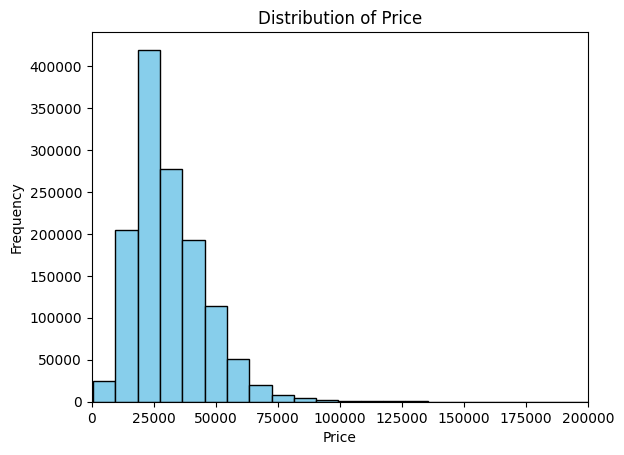

In [142]:
plt.hist(cleaned_cars['price'], bins=300, color='skyblue', edgecolor='black')
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim([0,200000])
plt.show()

### II) for price column - Boxplot

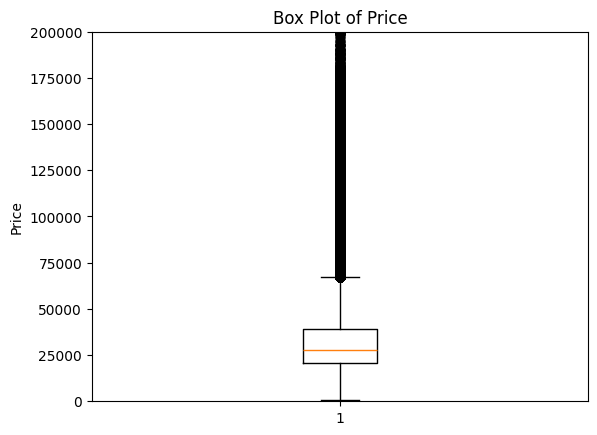

In [143]:
plt.boxplot(cleaned_cars['price'])
plt.title('Box Plot of Price')
plt.ylabel('Price')
plt.ylim([0,200000])
plt.show()

#### We see from the above boxplot that our final target column - 'price' which is the final price of the used car, contains several outliers we can either directly remove them or can keep them in the dataset. For now we choose to keep them because these values are the actual value and the model can depend on these values. 

### III) for year column - Histogram-

<Axes: xlabel='year', ylabel='Count'>

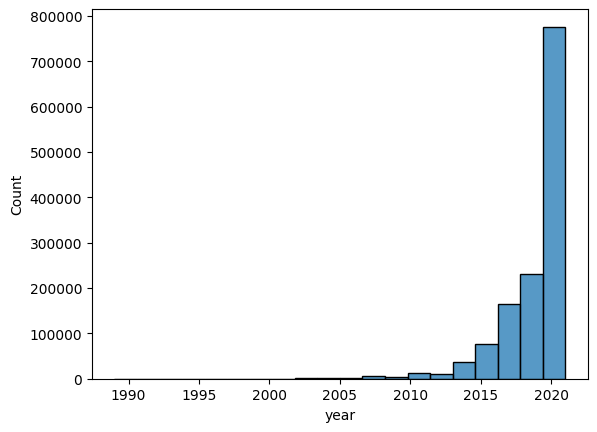

In [144]:

sns.histplot(data=cleaned_cars,x='year',bins=20)

#### Above plot shows sales of cars over the years. We can see it is left skewed.

C:\Users\AAYUSH\AppData\Local\Temp\ipykernel_1588\1466270632.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fuel_type', data=cleaned_cars, palette="viridis")


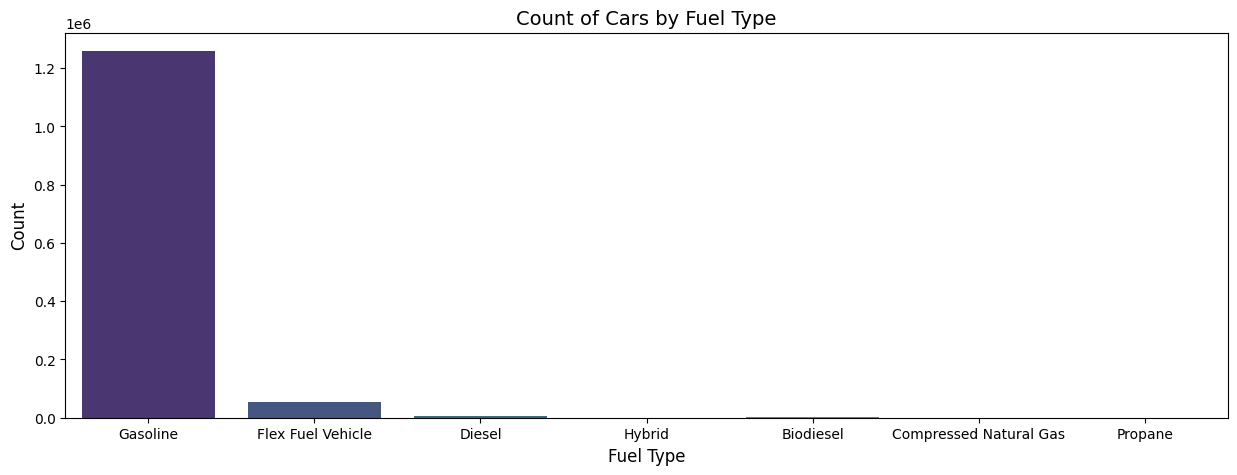

In [145]:
plt.figure(figsize=(15, 5))
sns.countplot(x='fuel_type', data=cleaned_cars, palette="viridis")
plt.title("Count of Cars by Fuel Type", fontsize=14)
plt.xlabel("Fuel Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

In [146]:
#above plot shows that max cars have fuel_type- 'Gasoline'

### 2. Bivariate analysis

### I) for price vs city_fuel_economy - scatter plot

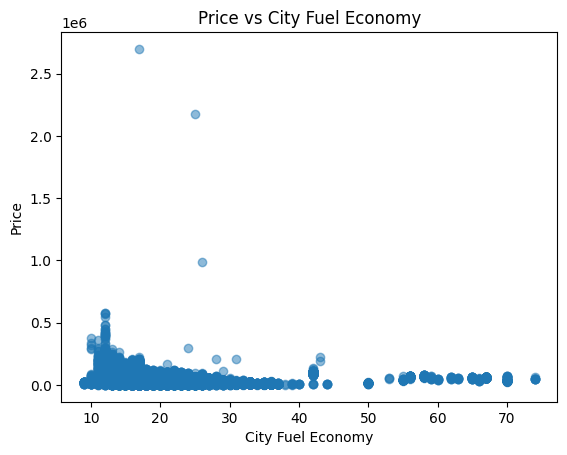

In [147]:
plt.scatter(cleaned_cars['city_fuel_economy'], cleaned_cars['price'], alpha=0.5)
plt.title('Price vs City Fuel Economy')
plt.xlabel('City Fuel Economy')
plt.ylabel('Price')
plt.show()

### II) for body_type vs price - Bar plot

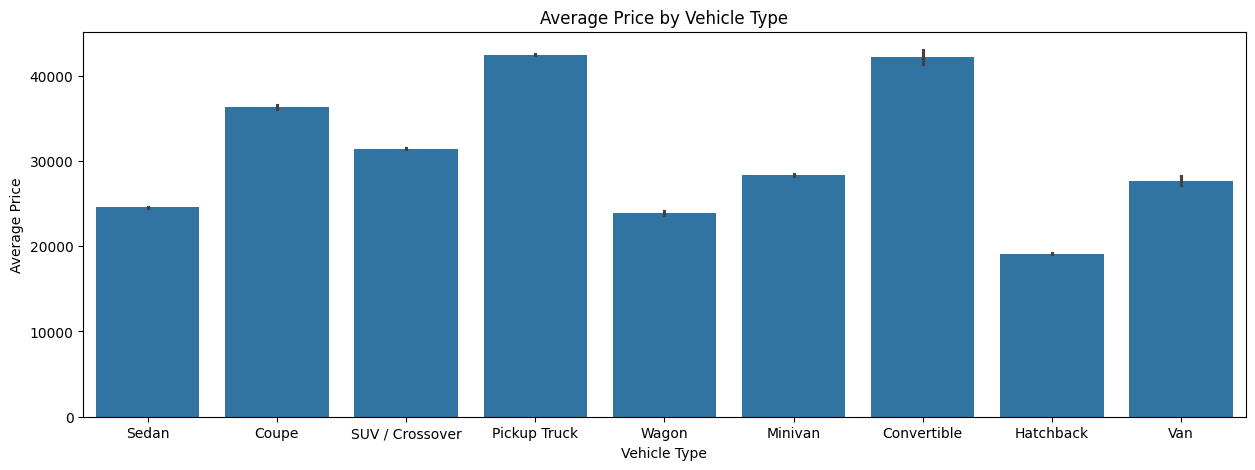

In [148]:
plt.figure(figsize=(15,5))
sns.barplot(x='body_type', y='price', data=cleaned_cars)
plt.title('Average Price by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Average Price')
plt.show()

(0.0, 200000.0)

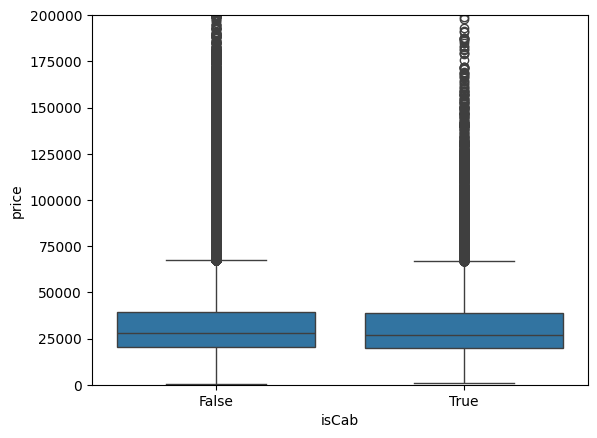

In [149]:
sns.boxplot(data=cleaned_cars,x='isCab',y='price')
plt.ylim([0,200000])

#### The above boxplot shows that it does not matter whether the car is a cab or not because it gives nearly the same value for price whether the car is a cab or not.

(0.0, 200000.0)

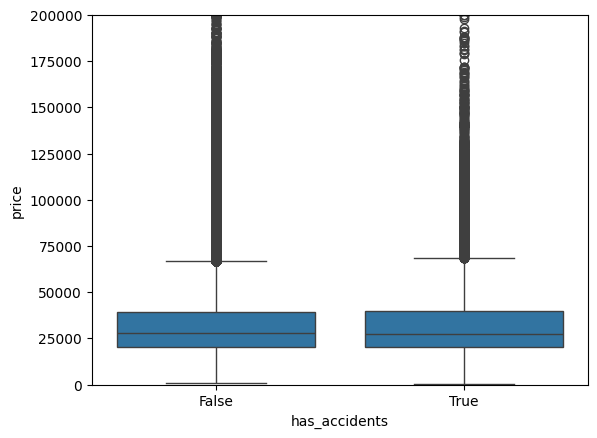

In [150]:
sns.boxplot(data=cleaned_cars,x='has_accidents',y='price')
plt.ylim([0,200000])

#### the above boxplot shows that it does not matter whether the car has met with an accident or not because it gives nearly the same value for accident occurence. So we do not use this for model training.

(0.0, 200000.0)

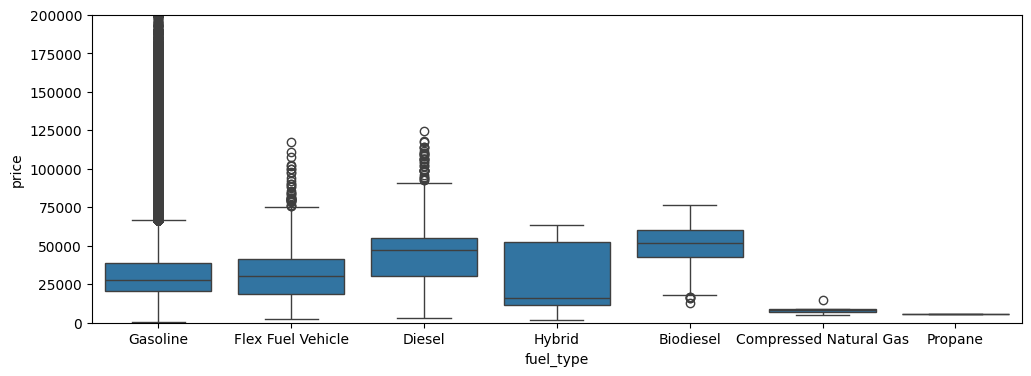

In [151]:
plt.figure(figsize=(12,4))
sns.boxplot(data=cleaned_cars,x='fuel_type',y='price')
plt.ylim([0,200000])

(0.0, 200000.0)

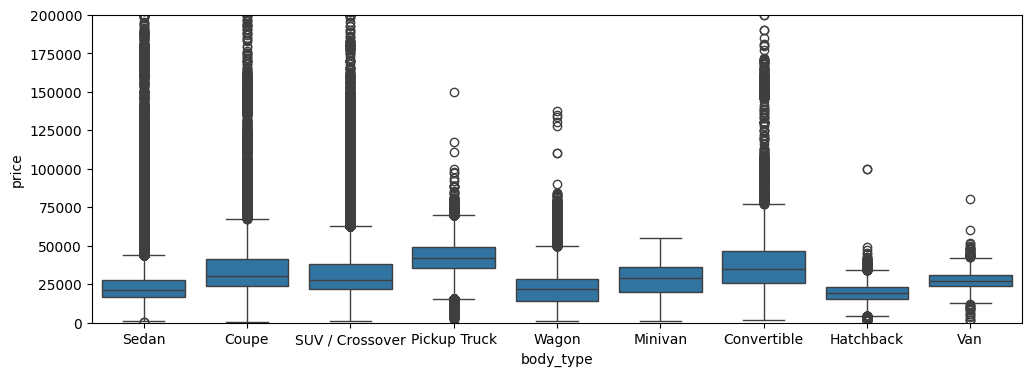

In [152]:
plt.figure(figsize=(12,4))
sns.boxplot(data=cleaned_cars,x='body_type',y='price')
plt.ylim([0,200000])

(0.0, 100000.0)

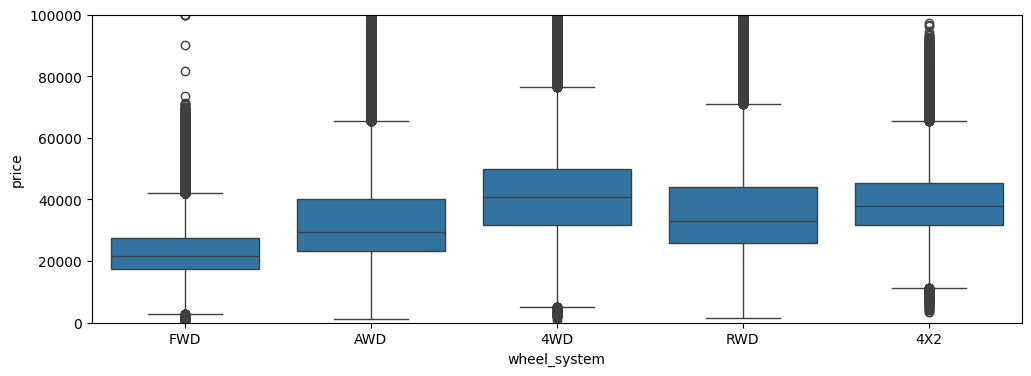

In [153]:
plt.figure(figsize=(12,4))
sns.boxplot(data=cleaned_cars,x='wheel_system',y='price')
plt.ylim([0,100000])

In [154]:
# 

(0.0, 100000.0)

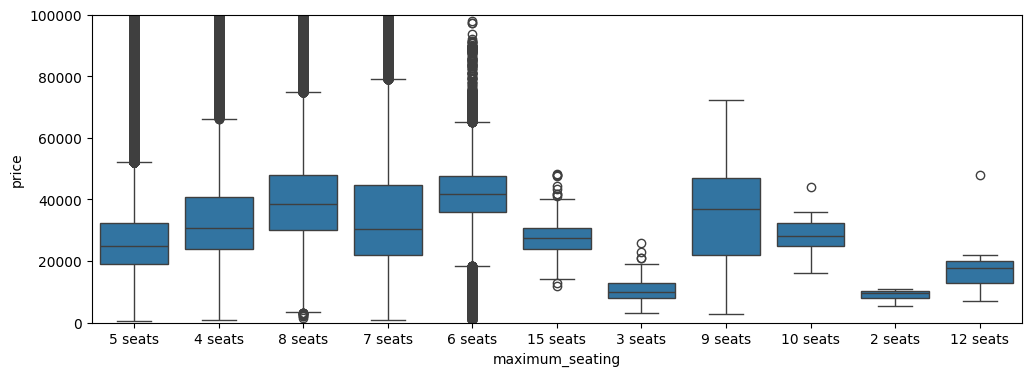

In [155]:
plt.figure(figsize=(12,4))
sns.boxplot(data=cleaned_cars,x='maximum_seating',y='price')
plt.ylim([0,100000])

(0.0, 100000.0)

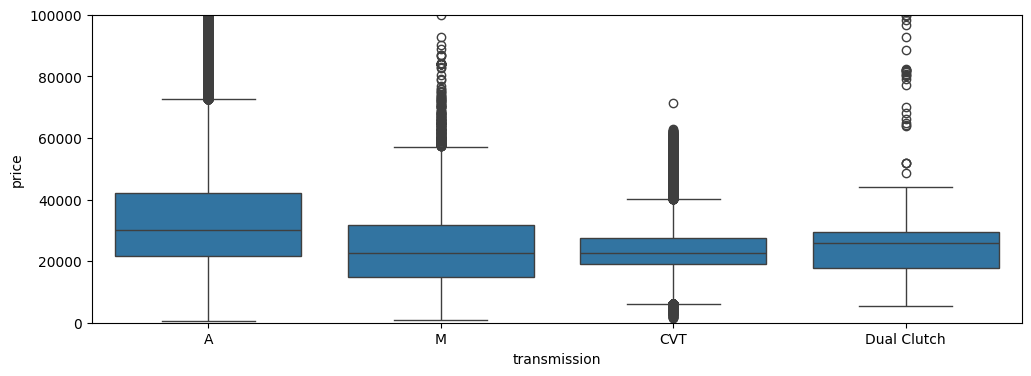

In [156]:
plt.figure(figsize=(12,4))
sns.boxplot(data=cleaned_cars,x='transmission',y='price')
plt.ylim([0,100000])

(0.0, 100000.0)

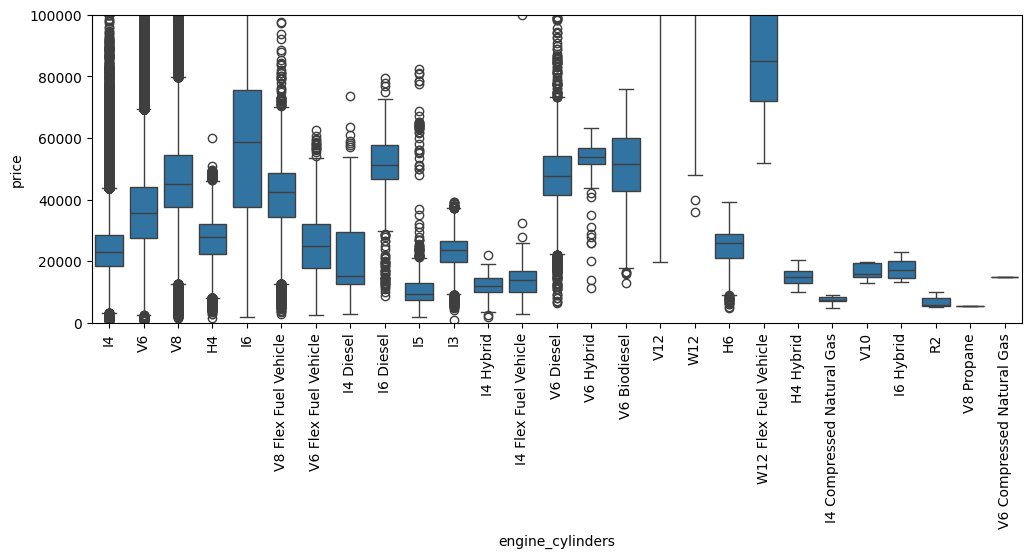

In [157]:
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
sns.boxplot(data=cleaned_cars,x='engine_cylinders',y='price')
plt.ylim([0,100000])


#### We can see from the above boxplot that engine_cylinders do affect the 'price' column.

(0.0, 100000.0)

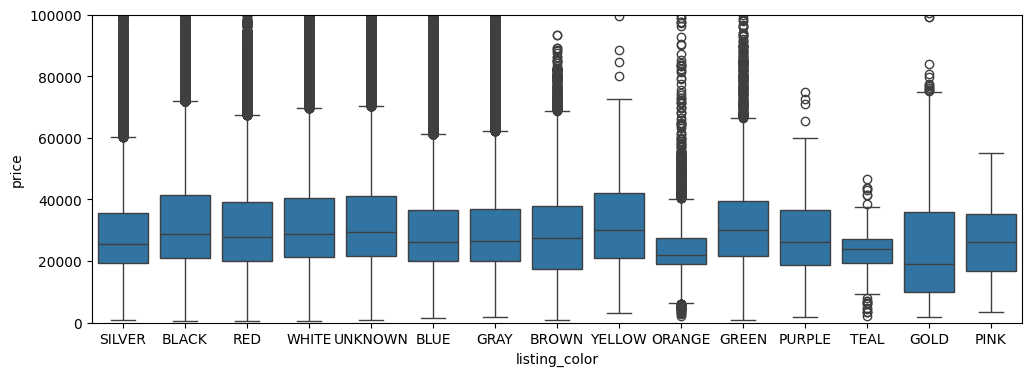

In [158]:
plt.figure(figsize=(12,4))
sns.boxplot(data=cleaned_cars,x='listing_color',y='price')
plt.ylim([0,100000])

#does not affect a lot

<Axes: xlabel='year', ylabel='price'>

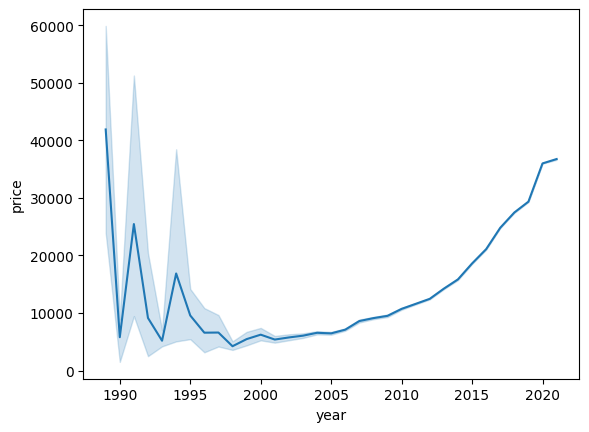

In [159]:
sns.lineplot(data=cleaned_cars,x='year',y='price')

#### Above plot shows price of cars over the years. The trend shows that before the year 2000, the prices of the cars were higher as compared to after the year 2000.

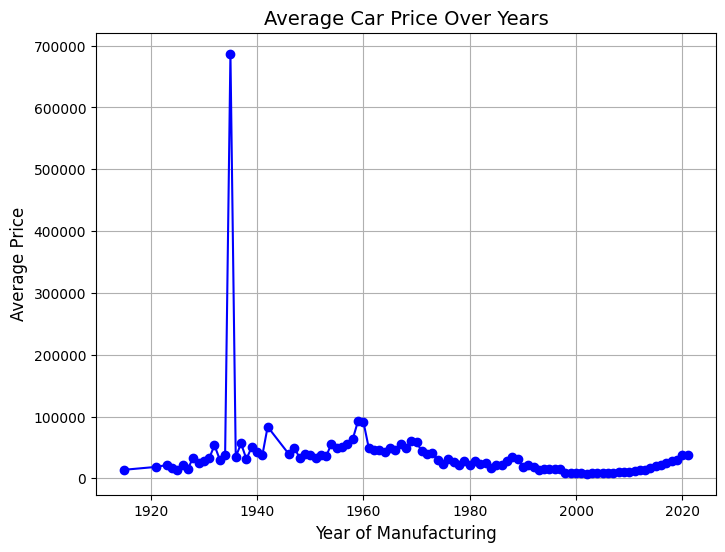

In [160]:
plt.figure(figsize=(8, 6))
avg_price_per_year = cars.groupby('year')['price'].mean()
avg_price_per_year.plot(kind='line', marker='o', color='blue')
plt.title("Average Car Price Over Years", fontsize=14)
plt.xlabel("Year of Manufacturing", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.grid()
plt.show()

### 3. Multivariate analysis

### I) for body_type and city_fuel_economy vs price

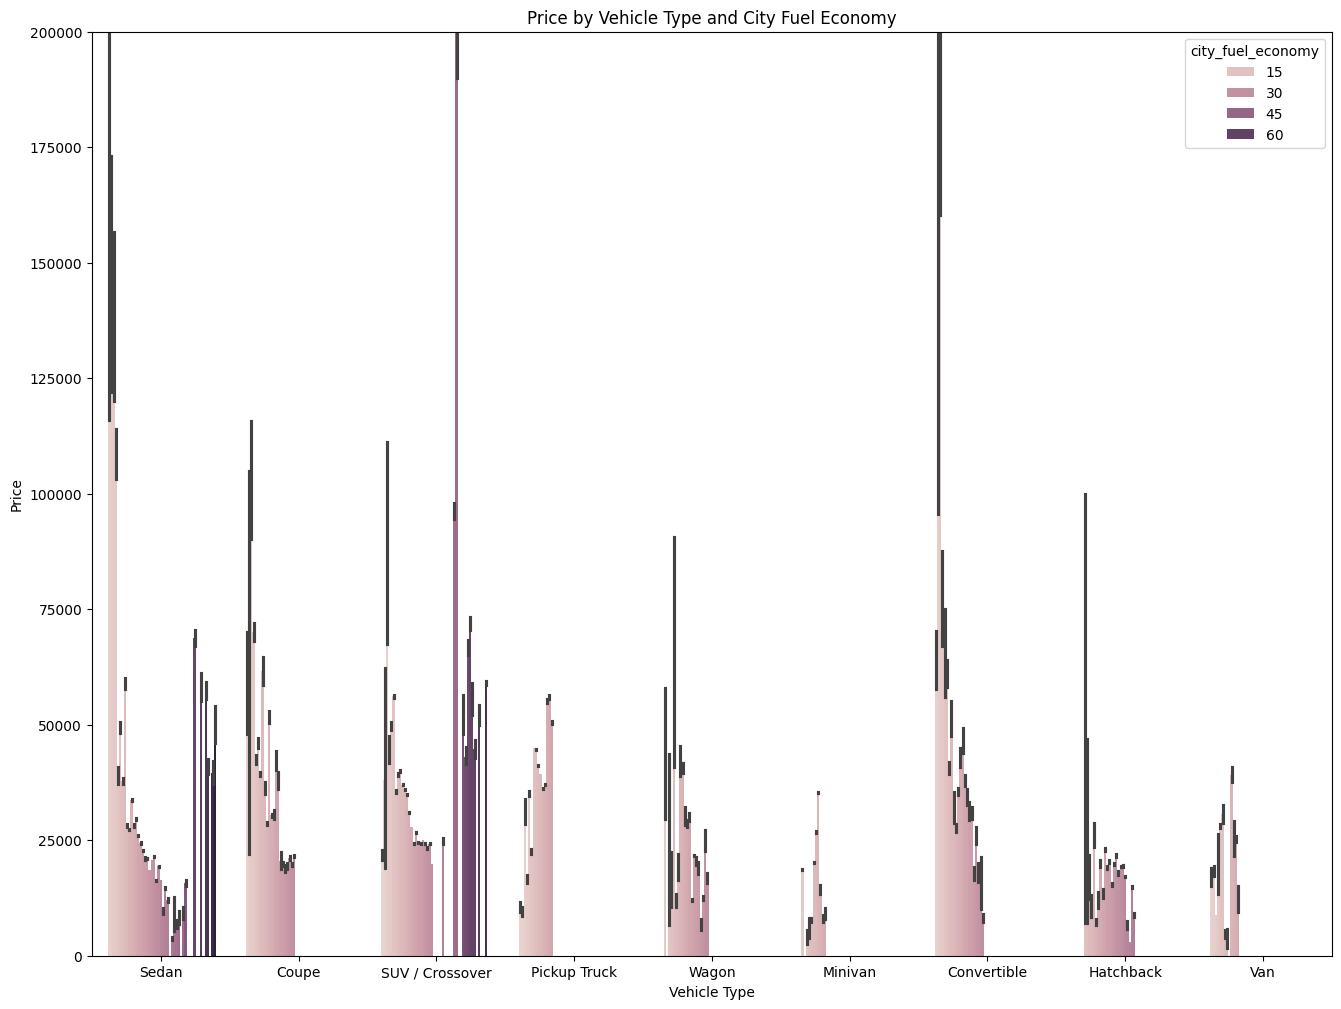

In [161]:
plt.figure(figsize=(16,12))
sns.barplot(x='body_type', y='price', hue='city_fuel_economy', data=cleaned_cars)
plt.title('Price by Vehicle Type and City Fuel Economy')
plt.xlabel('Vehicle Type')
plt.ylabel('Price')
plt.ylim([0,200000])
plt.show()

In [162]:
categorical_columns = cleaned_cars.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)

Index(['body_type', 'city', 'dealer_zip', 'engine_cylinders', 'exterior_color',
       'fleet', 'franchise_make', 'fuel_type', 'has_accidents',
       'interior_color', 'isCab', 'listed_date', 'listing_color', 'make_name',
       'maximum_seating', 'model_name', 'power', 'sp_name', 'torque',
       'transmission', 'transmission_display', 'trim_name', 'wheel_system',
       'wheel_system_display', 'width'],
      dtype='object')


In [163]:
for_corr=cleaned_cars[['city_fuel_economy', 'daysonmarket', 'engine_displacement',
       'highway_fuel_economy', 'horsepower',
       'mileage', 'owner_count', 'savings_amount', 'seller_rating','back_legroom', 'front_legroom', 'fuel_tank_volume', 'height', 'length','wheelbase','price']]

In [164]:
corr_mat = for_corr.corr().round(2)

In [165]:
for_corr.corr()['price']

city_fuel_economy      -0.465759
daysonmarket            0.114841
engine_displacement     0.464442
highway_fuel_economy   -0.488465
horsepower              0.664264
mileage                -0.417809
owner_count            -0.248847
savings_amount         -0.075997
seller_rating           0.103422
back_legroom            0.300655
front_legroom           0.038967
fuel_tank_volume        0.522482
height                  0.414715
length                  0.467972
wheelbase               0.466495
price                   1.000000
Name: price, dtype: float64

<Axes: >

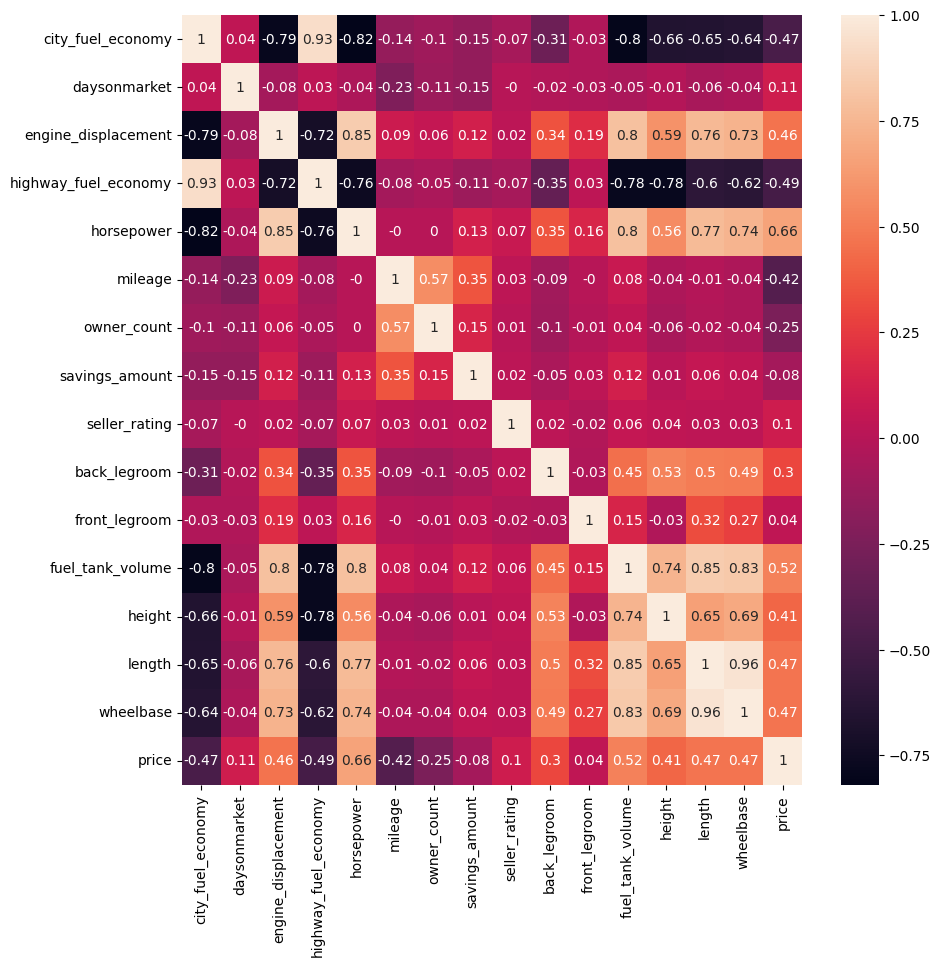

In [166]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_mat,annot=True)

In [167]:
cleaned_cars['engine_cylinders'].value_counts()

engine_cylinders
I4                           688744
V6                           376242
V8                           125506
H4                            35232
V6 Flex Fuel Vehicle          29084
V8 Flex Fuel Vehicle          22238
I3                            20115
I6                            10964
I6 Diesel                      3836
V6 Biodiesel                   2718
I4 Flex Fuel Vehicle           2550
I4 Diesel                      1926
V6 Diesel                      1204
I5                              778
H6                              744
I4 Hybrid                       282
V12                             249
V6 Hybrid                       194
W12                             145
H4 Hybrid                        41
W12 Flex Fuel Vehicle            12
I4 Compressed Natural Gas         6
V10                               5
I6 Hybrid                         4
R2                                3
V8 Propane                        1
V6 Compressed Natural Gas         1
Name: count

In [168]:
cleaned_cars['listing_color'].value_counts()

listing_color
BLACK      275979
WHITE      270739
UNKNOWN    179875
SILVER     173021
GRAY       172271
RED        113655
BLUE       113043
GREEN        8376
BROWN        5260
ORANGE       5154
TEAL         1925
YELLOW       1588
GOLD         1573
PURPLE        327
PINK           38
Name: count, dtype: int64

In [169]:
cleaned_cars.isna().sum()

back_legroom            0
body_type               0
city                    0
city_fuel_economy       0
daysonmarket            0
dealer_zip              0
engine_cylinders        0
engine_displacement     0
exterior_color          0
fleet                   0
frame_damaged           0
franchise_dealer        0
franchise_make          0
front_legroom           0
fuel_tank_volume        0
fuel_type               0
has_accidents           0
height                  0
highway_fuel_economy    0
horsepower              0
interior_color          0
isCab                   0
is_new                  0
latitude                0
length                  0
listed_date             0
listing_color           0
longitude               0
make_name               0
maximum_seating         0
mileage                 0
model_name              0
owner_count             0
power                   0
price                   0
savings_amount          0
seller_rating           0
sp_name                 0
torque      

In [170]:
cont_cols=['city_fuel_economy', 'daysonmarket', 'engine_displacement',
       'highway_fuel_economy', 'horsepower',
       'mileage', 'owner_count', 'savings_amount', 'seller_rating','back_legroom', 'front_legroom', 'fuel_tank_volume', 'height', 'length','wheelbase','price']

In [171]:
cat_cols=['wheel_system','body_type','fuel_type','maximum_seating','engine_cylinders','make_name','listing_color']

#### Exploratory Data Analysis showed that the above columns had the maximum contribution for the target column - 'price' hence we choose these columns for our final model.

In [172]:
df=cleaned_cars.copy()


In [173]:
#Takes time to run-
from sklearn.feature_selection import SelectKBest
# df = pd.read_excel('CDAC_DataBook.xlsx', sheet_name='diabetes')
df=cleaned_cars[cont_cols]
bf = SelectKBest(k=8)
x=df.drop('price', axis=1)
y=df['price']
fit = bf.fit(x,y)
d1={"Factors":x.columns,'Scores':fit.scores_}
res = pd.DataFrame(d1)


In [174]:
res=res.sort_values(by='Scores',ascending=False)
res

,Factors,Scores
4,horsepower,27.876495
5,mileage,25.512985
11,fuel_tank_volume,16.519667
0,city_fuel_economy,15.006295
3,highway_fuel_economy,14.452707
14,wheelbase,13.822028
13,length,13.148661
2,engine_displacement,12.550719
12,height,10.946646
6,owner_count,7.429769


In [175]:
# #Most imp continuous columns-
#                  Factors     Scores
# 4             horsepower  27.876495
# 5                mileage  25.512985
# 11      fuel_tank_volume  16.519667
# 0      city_fuel_economy  15.006295
# 3   highway_fuel_economy  14.452707
# 14             wheelbase  13.822028
# 13                length  13.148661
# 2    engine_displacement  12.550719
# 12                height  10.946646
# 6            owner_count   7.429769
# 7         savings_amount   6.289526
# 9           back_legroom   6.136403
# 1           daysonmarket   3.157217
# 10         front_legroom   3.076022
# 8          seller_rating   2.049434

In [176]:
df.columns

Index(['city_fuel_economy', 'daysonmarket', 'engine_displacement',
       'highway_fuel_economy', 'horsepower', 'mileage', 'owner_count',
       'savings_amount', 'seller_rating', 'back_legroom', 'front_legroom',
       'fuel_tank_volume', 'height', 'length', 'wheelbase', 'price'],
      dtype='object')

In [177]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway

categorical_features=cat_cols
df=cleaned_cars.copy()
#categorical_features = ['Category1', 'Category2', 'Category3']  # Replace with actual column names

for col in categorical_features:
    groups = [df[df[col] == val]['price'] for val in df[col].unique()]
    anova_stat, p_value = f_oneway(*groups)
    
    print(f"{col}: p-value = {p_value:.5f}")
    if p_value < 0.05:
        print(f"✅ {col} is significant for predicting the target.\n")
    else:
        print(f"❌ {col} is NOT significant.\n")


wheel_system: p-value = 0.00000
✅ wheel_system is significant for predicting the target.

body_type: p-value = 0.00000
✅ body_type is significant for predicting the target.

fuel_type: p-value = 0.00000
✅ fuel_type is significant for predicting the target.

maximum_seating: p-value = 0.00000
✅ maximum_seating is significant for predicting the target.

engine_cylinders: p-value = 0.00000
✅ engine_cylinders is significant for predicting the target.

make_name: p-value = 0.00000
✅ make_name is significant for predicting the target.

listing_color: p-value = 0.00000
✅ listing_color is significant for predicting the target.



**The above statistical test also proves along with EDA that the above categoical columns are important for predicting the final price of the used car.**

In [178]:

cont_cols=res.head(9)['Factors'].tolist() #taaking only top 9 values
cont_cols

['horsepower',
 'mileage',
 'fuel_tank_volume',
 'city_fuel_economy',
 'highway_fuel_economy',
 'wheelbase',
 'length',
 'engine_displacement',
 'height']

In [179]:
cat_cols=['wheel_system','body_type','fuel_type','maximum_seating','engine_cylinders','make_name','listing_color']

In [180]:
all_cols=cont_cols+cat_cols

In [268]:
all_cols

['horsepower',
 'mileage',
 'fuel_tank_volume',
 'city_fuel_economy',
 'highway_fuel_economy',
 'wheelbase',
 'length',
 'engine_displacement',
 'height',
 'wheel_system',
 'body_type',
 'fuel_type',
 'maximum_seating',
 'engine_cylinders',
 'make_name',
 'listing_color']

In [203]:
df=cleaned_cars[all_cols]

In [204]:
df.shape

(1322824, 16)

#### In the below step, we use one-hot encoding to convert categorical columns into numerical value columns which can be easily understood by our machine learning model. It creates different columns where the presence of a particular category is indicated by value 1 and its absence is indicated by value 0.

In [205]:
df2 = pd.get_dummies(df, columns=cat_cols, drop_first=True,dtype=int)


In [206]:
df2

,horsepower,mileage,fuel_tank_volume,city_fuel_economy,highway_fuel_economy,wheelbase,length,engine_displacement,height,wheel_system_4X2,...,listing_color_GREEN,listing_color_ORANGE,listing_color_PINK,listing_color_PURPLE,listing_color_RED,listing_color_SILVER,listing_color_TEAL,listing_color_UNKNOWN,listing_color_WHITE,listing_color_YELLOW
38,160.0,42394.0,15.8,27.0,36.0,111.4,193.8,1500.0,57.6,0,...,0,0,0,0,0,1,0,0,0,0
40,311.0,62251.0,17.4,18.0,24.0,107.5,184.8,3500.0,55.1,0,...,0,0,0,0,0,0,0,0,0,0
41,310.0,36410.0,19.4,18.0,27.0,120.9,204.3,3600.0,70.7,0,...,0,0,0,0,0,1,0,0,0,0
45,281.0,36055.0,22.0,15.0,22.0,118.9,203.7,3600.0,69.9,0,...,0,0,0,0,0,1,0,0,0,0
47,295.0,25745.0,24.6,18.0,25.0,114.8,189.8,3600.0,69.3,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000011,308.0,2.0,19.4,19.0,26.0,112.7,191.4,3600.0,67.0,0,...,0,0,0,0,0,0,0,0,0,0
3000024,375.0,25.0,27.8,16.0,21.0,131.6,221.9,3500.0,76.2,0,...,0,0,0,0,0,0,0,0,1,0
3000025,310.0,17035.0,15.5,21.0,32.0,107.1,188.5,2300.0,54.3,0,...,0,0,0,0,1,0,0,0,0,0
3000026,138.0,7444.0,14.0,26.0,31.0,100.6,167.6,1400.0,66.0,0,...,0,0,0,0,0,1,0,0,0,0


In [207]:
cleaned_cars['listing_color'].unique()

array(['SILVER', 'BLACK', 'RED', 'WHITE', 'UNKNOWN', 'BLUE', 'GRAY',
       'BROWN', 'YELLOW', 'ORANGE', 'GREEN', 'PURPLE', 'TEAL', 'GOLD',
       'PINK'], dtype=object)

#### We use the following step to get some of the best features of our dataset which we will use to train on our machine learning model.

In [208]:
# from sklearn.feature_selection import SelectKBest, f_regression
# import pandas as pd

# # Separate features and target
# x = df2.drop('price', axis=1)  # Features
# y = df2['price']  # Continuous target variable

# # Apply SelectKBest with a regression scoring function
# bf = SelectKBest(score_func=f_regression, k=12)
# fit = bf.fit(x, y)

# # Create a DataFrame with feature names and their corresponding scores
# d1 = {"Factors": x.columns, "Scores": fit.scores_}
# res = pd.DataFrame(d1)

# # Show the results
# print(res)
# res.head(25)

In [209]:
# res=res.sort_values(by='Scores',ascending=False)
# res.head(20)

In [210]:
# final_cols=res.head(25).Factors  #we take the 25 best features for our machine learning models to predict the target column - 'price'

In [211]:
# final_cols

In [212]:
# X=df2[final_cols]
# y=df2['price']

In [213]:
X=df2.copy()
y=cleaned_cars['price']

In [214]:
# 'X' stores predictor columns and 'y' stores target column
# X=df2[final_cols]
# y=df2['price']


#Train-Test Split- splitting the dataset-
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression Model-

#### OLS with scaling -

In [215]:
import statsmodels
from statsmodels import stats
from statsmodels.stats import weightstats as ssw

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

In [216]:
# Feature Scaling (useful for regression models)
from sklearn.preprocessing import LabelEncoder, StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [217]:
X_train_scaled=sm.add_constant(X_train_scaled,prepend=False)

In [218]:
mod_ols=sm.OLS(y_train,X_train_scaled).fit()

In [219]:
print(mod_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                 3.020e+04
Date:                Thu, 30 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:11:05   Log-Likelihood:            -1.0954e+07
No. Observations:             1058259   AIC:                         2.191e+07
Df Residuals:                 1058141   BIC:                         2.191e+07
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          8673.9680     25.098    345.605      0.0

#### OLS without scaling -

In [220]:
X_train=sm.add_constant(X_train,prepend=False)

In [221]:
mod_ols2=sm.OLS(y_train,X_train).fit()

In [222]:
print(mod_ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                 3.046e+04
Date:                Thu, 30 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:11:21   Log-Likelihood:            -1.0954e+07
No. Observations:             1058259   AIC:                         2.191e+07
Df Residuals:                 1058142   BIC:                         2.191e+07
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

#### Using Linear Regression model-

In [223]:
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.linear_model import LinearRegression 


# X=df2[final_cols]
# y=df2['price']
X=df2.copy()
y=cleaned_cars['price']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling (useful for regression models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training - Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [227]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [228]:
# Model Evaluation - Linear Regression
y_pred_lr = lr_model.predict(X_test_scaled)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Evaluation:")
print(f"MAE: {mae_lr}")
print(f"MSE: {mse_lr}")
print(f"R-squared: {r2_lr}")

Linear Regression Evaluation:
MAE: 4483.30920053784
MSE: 44505528.26154006
R-squared: 0.8110249856225827


In [229]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

## Ridge Regression

In [188]:
rr=Ridge()
parameters={'alpha':[0.000001,0.0001,.01,.5,.1,1,10,15,20,25,50,100]}
ridgecv=GridSearchCV(rr,parameters)
ridgecv.fit(scaler.fit_transform(X),y)
print(ridgecv.best_params_)

{'alpha': 100}


In [189]:
# Model Evaluation - Ridge Regression
y_pred_lr = ridgecv.predict(X_test_scaled)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Ridge Regression Evaluation:")
print(f"MAE: {mae_lr}")
print(f"MSE: {mse_lr}")
print(f"R-squared: {r2_lr}")

Ridge Regression Evaluation:
MAE: 5212.969268309679
MSE: 59041355.55862106
R-squared: 0.7493043796719888


## KNN (K-Nearest Neighbour)

In [230]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)  # we can tune 'n_neighbors'

# Fit the model
knn_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN MSE: {mse_knn}")
print(f"KNN R2 Score: {r2_knn}")

KNN MSE: 18150743.50018974
KNN R2 Score: 0.9229300909821292


#### Hyperparameter tuning for KNN

In [760]:
# This part should be commented because it takes a lot of time to test for best hyperparameter for KNN using Grid search cv

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the model
knn = KNeighborsRegressor()

# Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11]
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid
)

# Fit the grid search model
grid_search.fit(X_train_scaled, y_train)

# Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
# best_knn = grid_search.best_estimator_
# y_pred = best_knn.predict(X_test)
# print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


Best Parameters: {'n_neighbors': 11}


#### Best Parameters: {'n_neighbors': 11} for KNN using GridSearchCV

In [190]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the KNN model
knn_model = KNeighborsRegressor(n_neighbors=11)  

# Fit the model
knn_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN MSE: {mse_knn}")
print(f"KNN R2 Score: {r2_knn}")

KNN MSE: 14779789.463633753
KNN R2 Score: 0.9372435057961328


#### Thus KNN gives an improved r2 score with updated hyperparameter.

## Decision Tree Regressor

In [191]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)  # we can tune 'max_depth'

# Fit the model
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree MSE: {mse_dt}")
print(f"Decision Tree R2 Score: {r2_dt}")

Decision Tree MSE: 21460153.182101645
Decision Tree R2 Score: 0.9088779997779786


## Hyperparameter tuning for Decision Tree-

In [756]:
from sklearn.model_selection import GridSearchCV

mod2=DecisionTreeRegressor()
parameters={'max_depth':[2,3,4,6,7,8,9,10,11,12,13,15,20,25]}
dec_treecv=GridSearchCV(mod2,parameters)
dec_treecv.fit(X_train,y_train)
print(dec_treecv.best_params_)

{'max_depth': 10}


####  The above test shows that the best value for max_depth which is a hyperparameter is 10.

## Random Forest Regressor

In [231]:
# Model Training - Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Model Evaluation - Random Forest Regressor
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Regression Evaluation:")
print(f"MAE: {mae_rf}")
print(f"MSE: {mse_rf}")
print(f"R-squared: {r2_rf}")


Random Forest Regression Evaluation:
MAE: 2482.9267650089027
MSE: 12804459.105131743
R-squared: 0.9456309600625873


In [232]:
#Saving the rf model-
import joblib

# Save the model to a file
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [233]:
# To load the model back
loaded_model = joblib.load('random_forest_model.pkl')

In [236]:
all_cols

['horsepower',
 'mileage',
 'fuel_tank_volume',
 'city_fuel_economy',
 'highway_fuel_economy',
 'wheelbase',
 'length',
 'engine_displacement',
 'height',
 'wheel_system',
 'body_type',
 'fuel_type',
 'maximum_seating',
 'engine_cylinders',
 'make_name',
 'listing_color']

In [248]:
import pandas as pd

# Define column names
columns = ['horsepower', 'mileage', 'fuel_tank_volume', 'city_fuel_economy', 'highway_fuel_economy',
           'wheelbase', 'length', 'engine_displacement', 'height', 'wheel_system', 'body_type', 
           'fuel_type', 'maximum_seating', 'engine_cylinders', 'make_name', 'listing_color']

# Create a single row of data
data = [[300, 25000, 15, 20, 28, 110, 190, 3.5, 65, 'AWD', 'Sedan', 'Gasoline', 5, 6, 'Ford', 'Red']]

# Create DataFrame with one entry
df = pd.DataFrame(data, columns=columns)

# Display DataFrame
print(df)


   horsepower  mileage  fuel_tank_volume  city_fuel_economy  \
0         300    25000                15                 20   

   highway_fuel_economy  wheelbase  length  engine_displacement  height  \
0                    28        110     190                  3.5      65   

  wheel_system body_type fuel_type  maximum_seating  engine_cylinders  \
0          AWD     Sedan  Gasoline                5                 6   

  make_name listing_color  
0      Ford           Red  


In [249]:
df = pd.get_dummies(df, columns=['wheel_system', 'body_type', 'fuel_type', 'make_name', 'listing_color'],dtype=int)

In [250]:
df

,horsepower,mileage,fuel_tank_volume,city_fuel_economy,highway_fuel_economy,wheelbase,length,engine_displacement,height,maximum_seating,engine_cylinders,wheel_system_AWD,body_type_Sedan,fuel_type_Gasoline,make_name_Ford,listing_color_Red
0,300,25000,15,20,28,110,190,3.5,65,5,6,1,1,1,1,1


In [ ]:
# Load the original training feature names (you should have saved them earlier)
expected_features = joblib.load("feature_columns.pkl")  # Load feature names used in training

# Add missing columns with default value 0
for feature in expected_features:
    if feature not in df.columns:
        df[feature] = 0

# Drop unexpected columns that were not in training
df = df[expected_features]


In [257]:
df.columns

Index(['horsepower', 'mileage', 'fuel_tank_volume', 'city_fuel_economy',
       'highway_fuel_economy', 'wheelbase', 'length', 'engine_displacement',
       'height', 'maximum_seating', 'engine_cylinders', 'wheel_system_AWD',
       'body_type_Sedan', 'fuel_type_Gasoline', 'make_name_Ford',
       'listing_color_Red'],
      dtype='object')

In [261]:
X_train.columns

Index(['horsepower', 'mileage', 'fuel_tank_volume', 'city_fuel_economy',
       'highway_fuel_economy', 'wheelbase', 'length', 'engine_displacement',
       'height', 'wheel_system_4X2',
       ...
       'listing_color_GREEN', 'listing_color_ORANGE', 'listing_color_PINK',
       'listing_color_PURPLE', 'listing_color_RED', 'listing_color_SILVER',
       'listing_color_TEAL', 'listing_color_UNKNOWN', 'listing_color_WHITE',
       'listing_color_YELLOW'],
      dtype='object', length=123)

In [262]:
import pandas as pd

# Assuming df is your DataFrame
columns_list = X_train.columns.tolist()
print(columns_list)


['horsepower', 'mileage', 'fuel_tank_volume', 'city_fuel_economy', 'highway_fuel_economy', 'wheelbase', 'length', 'engine_displacement', 'height', 'wheel_system_4X2', 'wheel_system_AWD', 'wheel_system_FWD', 'wheel_system_RWD', 'body_type_Coupe', 'body_type_Hatchback', 'body_type_Minivan', 'body_type_Pickup Truck', 'body_type_SUV / Crossover', 'body_type_Sedan', 'body_type_Van', 'body_type_Wagon', 'fuel_type_Compressed Natural Gas', 'fuel_type_Diesel', 'fuel_type_Flex Fuel Vehicle', 'fuel_type_Gasoline', 'fuel_type_Hybrid', 'fuel_type_Propane', 'maximum_seating_12 seats', 'maximum_seating_15 seats', 'maximum_seating_2 seats', 'maximum_seating_3 seats', 'maximum_seating_4 seats', 'maximum_seating_5 seats', 'maximum_seating_6 seats', 'maximum_seating_7 seats', 'maximum_seating_8 seats', 'maximum_seating_9 seats', 'engine_cylinders_H4 Hybrid', 'engine_cylinders_H6', 'engine_cylinders_I3', 'engine_cylinders_I4', 'engine_cylinders_I4 Compressed Natural Gas', 'engine_cylinders_I4 Diesel', 'en

In [273]:
# List of expected features
expected_features =columns_list

# Create a dictionary with actual values
single_entry_data = {
    'horsepower': 300,
    'mileage': 25000,
    'fuel_tank_volume': 15,
    'city_fuel_economy': 20,
    'highway_fuel_economy': 28,
    'wheelbase': 110,
    'length': 190,
    'engine_displacement': 3.5,
    'height': 65,
    'maximum_seating': 5,
    'engine_cylinders': 6,
    'wheel_system_FWD': 1,
    'body_type_Sedan': 1,
    'fuel_type_Gasoline': 1,
    'make_name_Ford': 1,
    'listing_color_YELLOW': 1
}

# Create a DataFrame with all expected features
single_entry_df = pd.DataFrame([{col: single_entry_data.get(col, 0) for col in expected_features}])

# Display the DataFrame
print(single_entry_df)

   horsepower  mileage  fuel_tank_volume  city_fuel_economy  \
0         300    25000                15                 20   

   highway_fuel_economy  wheelbase  length  engine_displacement  height  \
0                    28        110     190                  3.5      65   

   wheel_system_4X2  ...  listing_color_GREEN  listing_color_ORANGE  \
0                 0  ...                    0                     0   

   listing_color_PINK  listing_color_PURPLE  listing_color_RED  \
0                   0                     0                  0   

   listing_color_SILVER  listing_color_TEAL  listing_color_UNKNOWN  \
0                     0                   0                      0   

   listing_color_WHITE  listing_color_YELLOW  
0                    0                     1  

[1 rows x 123 columns]


In [274]:
# Make predictions on the entire dataset
predictions = loaded_model.predict(single_entry_df)

# Add predictions to the DataFrame
df['predictions'] = predictions

# # Save results
# df.to_csv("predicted_used_cars.csv", index=False)

# print("Predictions saved successfully!")


In [275]:
df

,horsepower,mileage,fuel_tank_volume,city_fuel_economy,highway_fuel_economy,wheelbase,length,engine_displacement,height,maximum_seating,engine_cylinders,wheel_system_AWD,body_type_Sedan,fuel_type_Gasoline,make_name_Ford,listing_color_Red,predictions
0,300,25000,15,20,28,110,190,3.5,65,5,6,1,1,1,1,1,19898.3


In [272]:
df

,horsepower,mileage,fuel_tank_volume,city_fuel_economy,highway_fuel_economy,wheelbase,length,engine_displacement,height,maximum_seating,engine_cylinders,wheel_system_AWD,body_type_Sedan,fuel_type_Gasoline,make_name_Ford,listing_color_Red,predictions
0,300,25000,15,20,28,110,190,3.5,65,5,6,1,1,1,1,1,31442.45


In [267]:
print(predictions)

[31330.81]


In [ ]:
user_input = {
    'horsepower',
 'mileage',
 'fuel_tank_volume',
 'city_fuel_economy',
 'highway_fuel_economy',
 'wheelbase',
 'length',
 'engine_displacement',
 'height',
 'wheel_system',
 'body_type',
 'fuel_type',
 'maximum_seating',
 'engine_cylinders',
 'make_name',
 'listing_color'
}

## Hyperparameter tuning for Random Forest model-

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [80,90,100,120,150, 200],
    'max_depth': [10, 20, 30]
}

# Perform Grid Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,

)

# Fit the grid search model
random_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", random_search.best_params_)

## Conclusion - 
- The data contained around 30% null values. We cleaned the data by imputing the null values with the proportion of different values non-null in the respective columns. We alse filled the null values using the median and mode of the respective columns.
- After cleaning the dataset we performed Exploratory Data Analysis(EDA) on the data. We did univariate,bivariate and multivariate analysis of various columns using plots such as boxplot,lineplot,histogram,heatmap,etc to gain insights on the columns which had a substantial impact on the target column - 'price'.
- Columns like  horsepower,fuel_tank_volume,highway_fuel_economy,length,wheelbase,city_fuel_economy,engine_displacement, wheel_system,engine_cylinders,mileage,height had a considerable impact on the target column - 'price'.
- We predicted the final price of the use car using various machine learning models like linear regression, K-Nearest Neighbours, Decision Trees and Random Forests. We were able to acheive an initial r2 score of **0.75** using the linear regression model which was our base model and used other models to check if the performance could be improved. Finally we were able to achieve an improved r2 score of **0.94** using the random forest model. We also performed hyperparameter tuning on the models to obtain the best hyperparameters for our model.